# CEIA - Análisis de Datos
## Trabajo Práctico Número 1

### Grupo: 

          - Martín A. Brocca 
          - Agustín A. Lopez Fredes 

Dataset seleccionado: [AirBnB Dataset](https://insideairbnb.com/get-the-data/)

In [2]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
import missingno as msno



#### El problema seleccionado cuenta con un dataset conformado por 7 archivos:
| **Archivo**                | **Descripción**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Listing.csv.gz         | Listado detallado de inmuebles                                               |
| Calendar.csv.gz        | Información detallada de fechas de reserva y ocupación                       |
| Reviews.csv.gz         | Listado detallado de opiniones y valoraciones de usuarios                    |
| Listing.csv            | Versión resumida del listado de inmuebles para facilitar visualizaciones     |
| Neighbourhoods.csv     | Listado de barrios de la localidad                                           |
| Neighbourhoods.geojson | Archivo GeoJson con los barrios de la localidad                              |


Se utilizarán los archivos detallados para el EDA, como así también el archivo geojson para la representación gráfica de algunas conclusiones o reportes.


In [3]:
#  URL para descargar todos los archivos que conforman el dataset
data_base_url = "https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2025-01-29"


# Definimos los nombres de los archivos y sus correspondientes URLs
data_files = {
    "df_listings_details": "/data/listings.csv.gz",
    "df_reviews_details": "/data/reviews.csv.gz",
    "df_calendar": "/data/calendar.csv.gz",
    "df_listings": "/visualisations/listings.csv",
    "df_reviews": "/visualisations/reviews.csv",
    "df_neighbourhoods": "/visualisations/neighbourhoods.csv",
}


# Carga directa de los archivos CSV desde la URL
dfs = {
    #name: pd.read_csv(base_url + filename, compression="gzip" if filename.endswith(".gz") else None)
    name: pd.read_csv(data_base_url + filename)
    for name, filename in data_files.items()
}
# Carga del archivo GeoJSON
dfs["df_neighbourhoods_geojson"] = gpd.read_file(
    data_base_url + "/visualisations/neighbourhoods.geojson"
)


In [4]:
# Creación de las variables individuales.
df_listings_details = dfs["df_listings_details"]
df_neighborhoods = dfs["df_neighbourhoods"]
df_reviews_details = dfs["df_reviews_details"]
df_calendar = dfs["df_calendar"]

In [5]:
#función para graficar los datos faltantes
def plot_missing(df, name):
    plt.figure(figsize=(20, 6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title(f"Missing Data Heatmap - {name}")
    plt.show()

In [6]:
# Función para informar las columnas con mayor cantidad de datos faltantes orderadas de mayor a menor
def report_missing(df):
    missing_report = (
        df.isnull().sum()
        .to_frame(name='missing_count')
        .assign(missing_pct=lambda x: (x['missing_count'] / len(df)) * 100)
        .query("missing_count > 0")
        .sort_values(by='missing_count', ascending=False)
    )
    return missing_report

In [7]:
# Función auxiliar para detectar outliers
def detectar_outliers(df):
    # Seleccionar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in columnas_numericas:
        # Calcular IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Límites para IQR con umbral 1.5
        limite_inferior_iqr_1_5 = Q1 - 1.5 * IQR
        limite_superior_iqr_1_5 = Q3 + 1.5 * IQR
        
        # Límites para IQR con umbral 3 (outliers severos)
        limite_inferior_iqr_3 = Q1 - 3 * IQR
        limite_superior_iqr_3 = Q3 + 3 * IQR

        # Calcular media y desviación estándar (umbral fijo de 3)
        mean = df[col].mean()
        std = df[col].std()
        limite_inferior_std = mean - 3 * std
        limite_superior_std = mean + 3 * std

        # Identificar outliers
        outliers_iqr_1_5 = df[(df[col] < limite_inferior_iqr_1_5) | (df[col] > limite_superior_iqr_1_5)]
        outliers_iqr_3 = df[(df[col] < limite_inferior_iqr_3) | (df[col] > limite_superior_iqr_3)]
        outliers_std = df[(df[col] < limite_inferior_std) | (df[col] > limite_superior_std)]

        # Calcular porcentajes
        total_data_points = len(df[col].dropna())
        outlier_percentage_iqr_1_5 = (len(outliers_iqr_1_5) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_iqr_3 = (len(outliers_iqr_3) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_std = (len(outliers_std) / total_data_points) * 100 if total_data_points > 0 else 0

        # Guardar resultados
        results.append({
            'Columna': col,
            'Porcentaje Outliers (Umbral 1.5 * IQR)': round(outlier_percentage_iqr_1_5, 2),
            'Porcentaje Outliers Severos (Umbral 3 * IQR)': round(outlier_percentage_iqr_3, 2),
            'Porcentaje Outliers (Umbral 3 * STD)': round(outlier_percentage_std, 2)
        })

    # Convertir resultados a DataFrame
    result_df = pd.DataFrame(results)
    
    # Ordenar por porcentaje de outliers (Umbral 1.5 * IQR) de mayor a menor
    result_df_sorted = result_df.sort_values(by='Porcentaje Outliers (Umbral 1.5 * IQR)', ascending=False)
    
    # Generar gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=result_df_sorted,
        x='Columna',
        y='Porcentaje Outliers (Umbral 1.5 * IQR)',
        color='#4e79a7'  # Azul oscuro compatible con temas claros y oscuros
    )
    plt.title('Porcentaje de Outliers por Columna (Umbral 1.5 * IQR)')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Outliers (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return result_df

In [8]:
#Análisis de los tamaños de los dataframes
summary = pd.DataFrame(
    [(name, df.shape[0], df.shape[1]) for name, df in dfs.items()],
    columns=["DataFrame", "Rows", "Columns"]
)

print(summary)
    

                   DataFrame      Rows  Columns
0        df_listings_details     35172       79
1         df_reviews_details    985786        6
2                df_calendar  12837777        7
3                df_listings     35172       18
4                 df_reviews    985786        2
5          df_neighbourhoods        49        2
6  df_neighbourhoods_geojson        49        3


## 1.Exploración y comprensión de los datos
Debido a que se tratan de varios datasets, para el EDA se procederá con el examen un dataset a la vez

<span style="font-size:24px; color:blue">Listing details</span>

In [9]:
#Visualización de primeros valores
df_listings_details.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11508,https://www.airbnb.com/rooms/11508,20250129142212,2025-01-30,city scrape,Amazing Luxurious Apt-Palermo Soho,LUXURIOUS 1 BDRM APT- POOL/ GYM/ 24-HR SECURIT...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,https://a0.muscache.com/pictures/19357696/b1de...,42762,...,4.98,4.93,4.86,NaN,f,1,1,0,0,0.29
1,14222,https://www.airbnb.com/rooms/14222,20250129142212,2025-01-30,city scrape,"RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES",Beautiful cozy apartment in excellent location...,Palermo is such a perfect place to explore the...,https://a0.muscache.com/pictures/4695637/bbae8...,87710233,...,4.90,4.87,4.75,NaN,f,6,6,0,0,0.80
2,15074,https://www.airbnb.com/rooms/15074,20250129142212,2025-01-30,previous scrape,ROOM WITH RIVER SIGHT,NaN,NaN,https://a0.muscache.com/pictures/91166/c0fdcb4...,59338,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,16695,https://www.airbnb.com/rooms/16695,20250129142212,2025-01-30,city scrape,DUPLEX LOFT 2 - SAN TELMO,NaN,San Telmo is one of the best neighborhoods in ...,https://a0.muscache.com/pictures/619c33a9-0618...,64880,...,4.80,4.39,4.41,NaN,t,9,9,0,0,0.27
4,20062,https://www.airbnb.com/rooms/20062,20250129142212,2025-01-30,city scrape,PENTHOUSE /Terrace & pool /City views /2bedrooms,NaN,NaN,https://a0.muscache.com/pictures/165679/2eb448...,75891,...,4.93,4.93,4.79,NaN,f,4,4,0,0,1.84


In [10]:
# Simplificamos dataset a las columnas de listing de interés
df_listings_columnas_interes = df_listings_details[['id','property_type', 'room_type', 
                                                    'accommodates', 'bedrooms', 'beds', 
                                                    'bathrooms','price', 'availability_eoy',
                                                    'estimated_occupancy_l365d', 'review_scores_rating',
                                                    'review_scores_accuracy', 'review_scores_cleanliness', 
                                                    'review_scores_checkin', 'review_scores_communication',
                                                    'review_scores_location',
                                                    'latitude', 'longitude', 
                                                    'review_scores_value','number_of_reviews','reviews_per_month', 
                                                    'neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed']]


In [11]:
df_listings_details['neighbourhood_group_cleansed'].unique()

array([nan])

In [12]:
# Revisión del tipos de datos
df_listings_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35172 entries, 0 to 35171
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            35172 non-null  int64  
 1   listing_url                                   35172 non-null  object 
 2   scrape_id                                     35172 non-null  int64  
 3   last_scraped                                  35172 non-null  object 
 4   source                                        35172 non-null  object 
 5   name                                          35172 non-null  object 
 6   description                                   34299 non-null  object 
 7   neighborhood_overview                         16588 non-null  object 
 8   picture_url                                   35171 non-null  object 
 9   host_id                                       35172 non-null 

Observamos que la variable precio es un string, lo cual es incorrecto. Procedemos a limpiarla de símbolos como "$" y a convertirla en numérica (float)

In [13]:
# Convertimos el precio en float, limpiando los caracteres previamente
# Elimina símbolo de dólar, comas y espacios, luego convierte a float
df_listings_details['price'] = (
    df_listings_details['price']
    .replace('[\$,]', '', regex=True)  # quita $ y ,
    .astype(float)
)

Tenemos 78 variables, con 35172 observaciones, aunque dependiendo de la columna algunas tienen valores nulos. Describiremos los principales tipos de variables:

| Variable  | Descripción | Tipo de variable |
|-----------|-------------|-----------|
| id   | id de la propiedad (permite hacer join con los demás dataset)   | Categórica nominal (es indicador único)  |
| neighbourhood_cleansed  | Barrio (columna ya limpia de errores/inconsistencias)   | Categórica nominal   |
| property_type| Tipo de propiedad (por ej chalet, condo). Incluye si la habitación es compartida o privada   | Categórica nominal   |
| room_type  | Tipo de habitación (compartida, privada, hotel, hogar entero)  | Categórica nominal    |
| bathrooms, bedrooms, beds| Cantidad de baños, habitaciones y camas respectivamente   | Cuantitativa discreta   |
| price   | Precio de la propiedad   | Cuantitativa continua   |
|  minimum_nights, maximum_nights   | Cantidad mínima y máxima de noches requerida   | Cuantitativa discreta   |
| number_of_reviews   | Cantidad de reviews recibidas  | Cuantitativa discreta   |
| availability_eoy    | Días que estuvo disponible al final del año  | Cuantitativa discreta   |
| review_scores  | Valores promedio de reviews de la propiedad. Cuenta con ratings por categoría y un valor general   | Cuantitativa continua  |
| reviews_per_month  | Cantidad de reviews promedio por mes   | Cuantitativa discreta   |

In [14]:
# Revisión del dataframe de listados
df_listings_details.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.517200e+04,3.517200e+04,3.517200e+04,35166.000000,35166.000000,0.0,35172.000000,35172.000000,35172.000000,31602.000000,...,29412.000000,29412.000000,29412.000000,29412.000000,29411.000000,35172.000000,35172.000000,35172.000000,35172.000000,29412.000000
mean,7.117880e+17,2.025013e+13,2.143294e+08,19.539641,29.425553,NaN,-34.591554,-58.417289,2.943535,1.236504,...,4.741915,4.865169,4.859413,4.870813,4.748523,15.646878,15.048277,0.526242,0.041766,1.325920
std,4.840974e+17,0.000000e+00,2.027420e+08,41.289336,79.583662,NaN,0.018257,0.030169,1.550894,0.656996,...,0.382239,0.307035,0.321622,0.263315,0.374513,34.108688,34.083499,2.653005,0.644463,1.336446
min,1.150800e+04,2.025013e+13,1.342600e+04,1.000000,1.000000,NaN,-34.693700,-58.530890,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,4.719776e+07,2.025013e+13,3.070016e+07,1.000000,1.000000,NaN,-34.602670,-58.437050,2.000000,1.000000,...,4.670000,4.850000,4.840000,4.840000,4.680000,1.000000,1.000000,0.000000,0.000000,0.360000
50%,8.875662e+17,2.025013e+13,1.421004e+08,3.000000,4.000000,NaN,-34.590890,-58.418914,2.000000,1.000000,...,4.840000,4.950000,4.960000,4.940000,4.840000,2.000000,2.000000,0.000000,0.000000,0.930000
75%,1.095206e+18,2.025013e+13,4.298024e+08,16.000000,20.000000,NaN,-34.581047,-58.392114,4.000000,1.000000,...,4.980000,5.000000,5.000000,5.000000,4.960000,12.000000,11.000000,0.000000,0.000000,1.910000
max,1.344330e+18,2.025013e+13,6.754917e+08,670.000000,2542.000000,NaN,-34.534980,-58.355403,16.000000,22.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,222.000000,222.000000,43.000000,14.000000,26.080000


In [15]:
# Describe para variables string
df_listings_details.describe(include="object")

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,...,property_type,room_type,bathrooms_text,amenities,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable
count,35172,35172,35172,35172,34299,16588,35171,35172,35166,35166,...,35172,35172,35148,35172,34005,35172,29412,29412,390,35172
unique,35172,4,2,32871,30441,13465,34512,17820,4344,4622,...,66,4,48,32741,2,4,3670,1757,365,2
top,https://www.airbnb.com/rooms/11508,2025-01-30,city scrape,Departamento en Buenos Aires,Enjoy the simplicity of this quiet and central...,"San Telmo, a historic neighborhood in Buenos A...",https://a0.muscache.com/pictures/hosting/Hosti...,https://www.airbnb.com/users/show/11256892,Federico,2014-01-13,...,Entire rental unit,Entire home/apt,1 bath,"[""Kitchen"", ""Air conditioning"", ""TV"", ""Wifi""]",t,2025-01-30,2024-12-01,2025-01-26,RL-2021-14800886,f
freq,1,26254,31613,98,148,64,9,222,533,245,...,25470,32083,25236,214,33940,26254,123,598,8,24046



<span style="font-size:24px; color:blue">Reviews details</span>

In [16]:
df_reviews_details.describe()

,listing_id,id,reviewer_id
count,9.857860e+05,9.857860e+05,9.857860e+05
mean,4.144489e+17,7.998363e+17,2.229755e+08
std,4.538855e+17,4.590446e+17,1.838945e+08
min,1.150800e+04,4.403400e+04,1.000000e+00
25%,2.482731e+07,5.970063e+17,5.817992e+07
50%,5.246691e+07,9.564739e+17,1.700336e+08
75%,8.592492e+17,1.155868e+18,3.834669e+08
max,1.340173e+18,1.345782e+18,6.754955e+08


In [17]:
# Revisión del tipos de datos
df_reviews_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985786 entries, 0 to 985785
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     985786 non-null  int64 
 1   id             985786 non-null  int64 
 2   date           985786 non-null  object
 3   reviewer_id    985786 non-null  int64 
 4   reviewer_name  985785 non-null  object
 5   comments       985741 non-null  object
dtypes: int64(3), object(3)
memory usage: 45.1+ MB


In [18]:
df_reviews_details.describe(include="object")

,date,reviewer_name,comments
count,985786,985785,985741
unique,4939,86559,931294
top,2023-11-12,Pablo,.
freq,2526,7665,2718


In [19]:
df_reviews_details['comments'].head(20)

0     Amazing place!\r<br/>\r<br/>Location: short wa...
1     Really enjoyed Candela's recommendations and q...
2     Candela and her colleague were very attentive ...
3     The apartment was in a beautiful, modern build...
4     My stay at Candela's apartment was very enjoya...
5     Very nice place, just as shown in the pictures...
6     Thank you for everything, Candela. Die Wohnung...
7     We had admired the Palermo Uno building on pre...
8     Candela did a great job accommodating us.  Whi...
9     Candela was a very good host. Although I did n...
10    Candela's apartment listing description was ac...
11    El apartamento es muy cómodo, tiene mucha luz ...
12    Great, indeed. \r<br/>\r<br/>Santiago welcomed...
13    El departamento de Santiago está en una excele...
14    El departamento de Santiago esta muy bien equi...
15                         ubicacion muy bueno y comodo
16    Increíble todo. El departamento es hermoso, mu...
17    El apartamento es espacioso, con terraza, 


<span style="font-size:24px; color:blue">Calendar</span>

In [20]:
df_calendar.describe()

,listing_id,adjusted_price,minimum_nights,maximum_nights
count,1.283778e+07,0.0,1.283776e+07,1.283776e+07
mean,7.117867e+17,NaN,6.025412e+00,6.112193e+02
std,4.840909e+17,NaN,2.418471e+01,4.453138e+02
min,1.150800e+04,NaN,1.000000e+00,1.000000e+00
25%,4.719456e+07,NaN,2.000000e+00,3.650000e+02
50%,8.875646e+17,NaN,2.000000e+00,3.650000e+02
75%,1.095203e+18,NaN,4.000000e+00,1.125000e+03
max,1.344330e+18,NaN,1.000000e+03,1.825000e+03


In [21]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12837777 entries, 0 to 12837776
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 685.6+ MB


In [22]:
df_calendar.describe(include="object")

,date,available,price
count,12837777,12837777,12837777
unique,369,2,781
top,2025-08-02,t,$30.00
freq,35172,7276094,799351


## 2. Limpieza del dataset

### 2.1 Detección valores nulos

<span style="font-size:24px; color:blue">Listing details</span>

Debido a la cantidad de columnas presentes en listing_details, nos centraremos en aquellas columnas que son de interés para el análisis en curso

In [23]:
# Simplificamos dataset a las columnas de listing de interés
df_listings_details_interes = df_listings_details[['id','property_type', 'room_type', 
                                           'name', 'description','accommodates', 'bedrooms', 'beds', 
                                            'bathrooms','price', 'availability_eoy',
                                            'estimated_occupancy_l365d', 'review_scores_rating',
                                            'review_scores_accuracy', 'review_scores_cleanliness',                                                     'review_scores_checkin', 'review_scores_communication',
                                            'review_scores_location','latitude', 'longitude', 
                                            'review_scores_value','number_of_reviews','reviews_per_month', 
                                            'neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
                                            'host_about', 'host_location', 'host_neighbourhood', 'host_listings_count']]

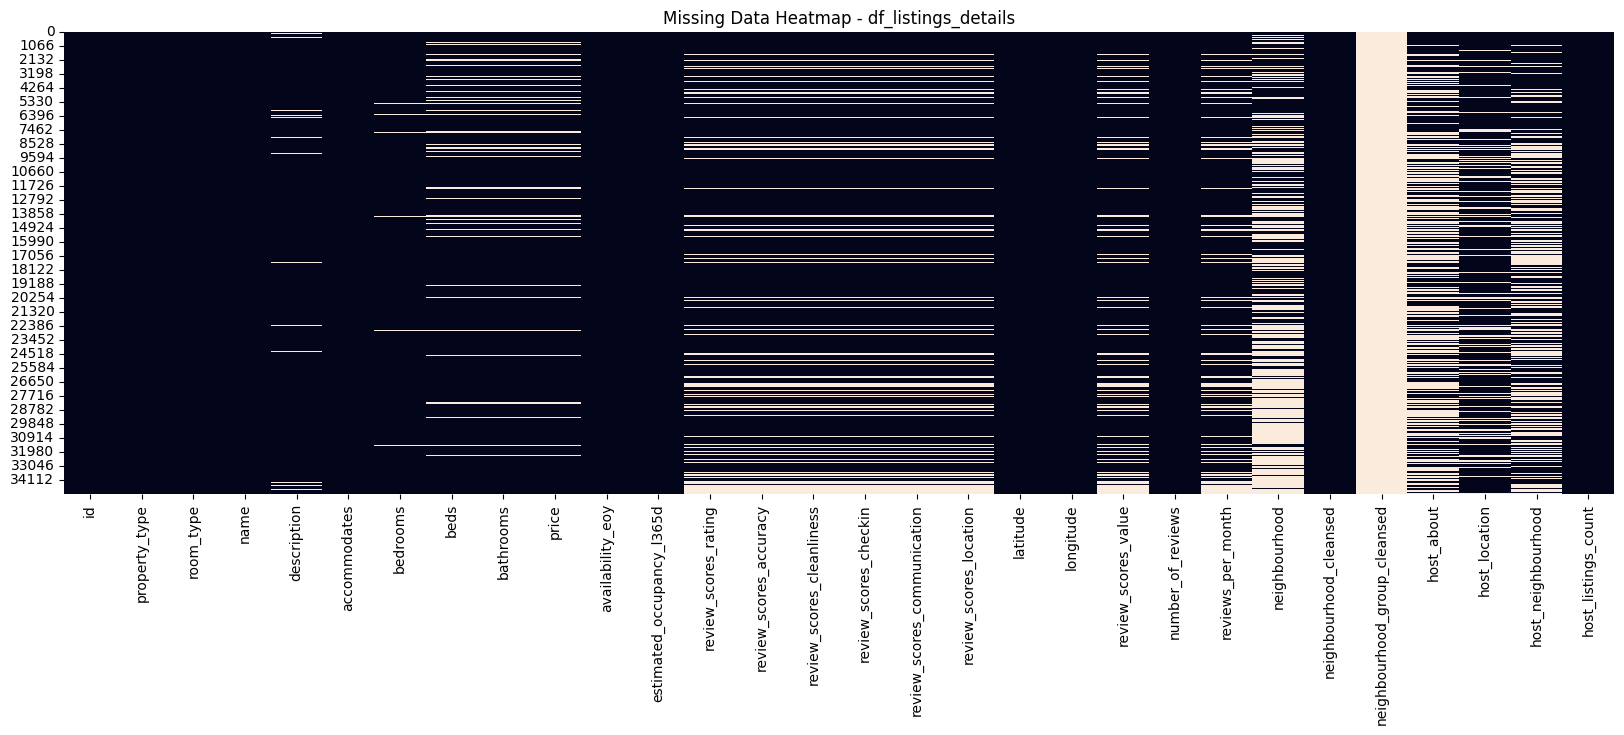

In [24]:
#Análisis de nulos:
plot_missing(df_listings_details_interes, "df_listings_details")

In [25]:
report_missing(df_listings_details_interes)

,missing_count,missing_pct
neighbourhood_group_cleansed,35172,100.000000
neighbourhood,18584,52.837484
host_about,16291,46.318094
host_neighbourhood,13451,38.243489
host_location,7553,21.474468
review_scores_accuracy,5761,16.379506
review_scores_value,5761,16.379506
review_scores_communication,5760,16.376663
review_scores_rating,5760,16.376663
review_scores_cleanliness,5760,16.376663


Del reporte se observan que las columnas neighbourhood_group_cleansed, calendar_updated y license están completamente o casi completamente vacías, lo que no permitirá su uso a futuros.

License: Corresponde a la licencia, permiso o número de registro. Es muy probable que muchas de las propiedades no cuenten con ellas al ser departamentos particulares.

Neighborhood and Neigborhood_overview, corresponden a valores que el host debe de completar en la publicación. El alto número de nulos se puede deber a factores tales como:
  - No ser necesario para la representación gráfica, al tener los valores de lat y long.
  - Evitar publicar barrios con peor ranking o mercado que puedan afectar el alquiler.

Host_about, host_location y host_neighborhood corresponden a la información del anfitrión (o dueño/responsable de la propiedad). 

In [26]:
#Analizamos los datos faltantes de los hosts, para ver si esto es mas frecuente en los hosts nuevos o aquellos con multiples listings:
# Creamos una máscara para las filas con datos faltantes:
missing_host_info = df_listings_details_interes[
    df_listings_details_interes[['host_about', 'host_location', 'host_neighbourhood']].isnull().any(axis=1)
]

# Agrupamos por host_listing_count para ver datos faltantes con el promedio de listados por host
missing_summary = (
    missing_host_info.groupby('host_listings_count')
    .size()
    .reset_index(name='missing_count')
    .sort_values(by='missing_count', ascending=False)
)

# Calculamos el porcentaje de datos faltantes por host_listings_count
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(missing_host_info)) * 100

missing_summary


,host_listings_count,missing_count,missing_pct
0,1.0,9672,43.838100
1,2.0,3438,15.582650
2,3.0,1674,7.587363
3,4.0,1072,4.858813
4,5.0,577,2.615238
...,...,...,...
59,131.0,5,0.022662
39,43.0,5,0.022662
65,320.0,2,0.009065
57,104.0,1,0.004532


C:\Users\alope\AppData\Local\Temp\ipykernel_3228\389697551.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


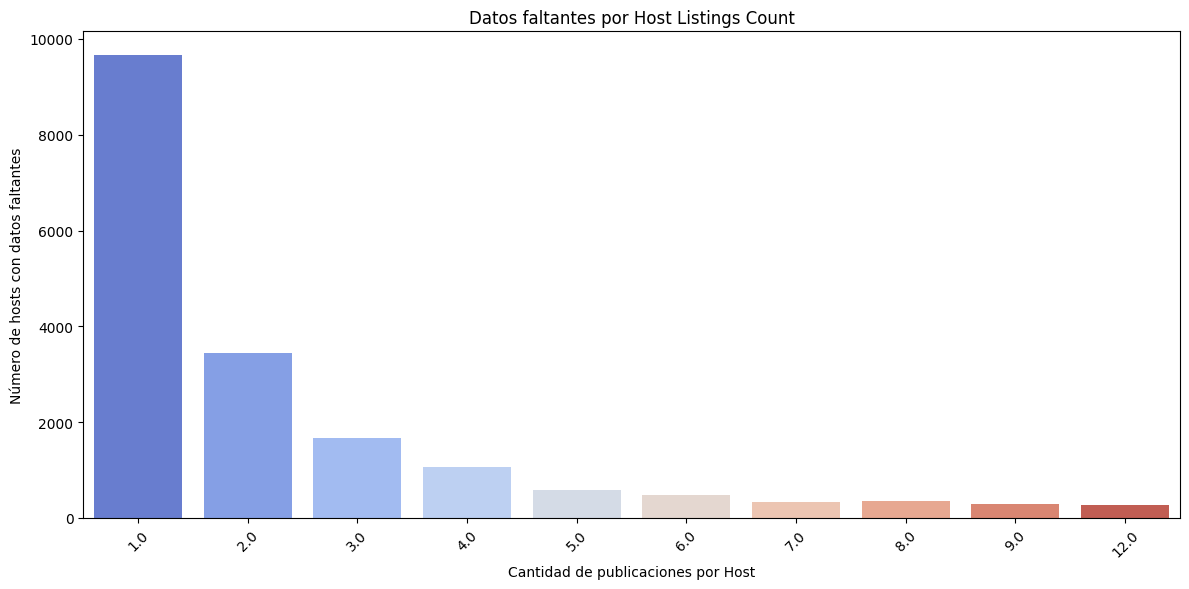

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=missing_summary.head(10),
    x='host_listings_count',
    y='missing_count',
    palette='coolwarm'
)
plt.title("Datos faltantes por Host Listings Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel("Cantidad de publicaciones por Host")
plt.ylabel("Número de hosts con datos faltantes")
plt.show()
plt.close()


In [28]:
missing_summary_by_prop_type = (
    missing_host_info.groupby('property_type')
    .size()
    .reset_index(name='missing_count')
    .sort_values(by='missing_count', ascending=False)
)

# Calculamos el porcentaje de datos faltantes por host_listings_count
missing_summary_by_prop_type['missing_pct'] = (missing_summary_by_prop_type['missing_count'] / len(missing_host_info)) * 100

missing_summary_by_prop_type.head(10)

,property_type,missing_count,missing_pct
15,Entire rental unit,15944,72.265784
7,Entire condo,2393,10.846213
16,Entire serviced apartment,755,3.422019
33,Private room in rental unit,712,3.227122
29,Private room in home,438,1.985224
13,Entire loft,401,1.817523
10,Entire home,331,1.500249
18,Entire vacation home,195,0.883833
43,Room in hotel,127,0.575624
26,Private room in condo,113,0.512170


Concluimos que aquellos hosts con 1 o 2 publicaciones son los que poseen una mayor cantidad de faltantes. También vemos que la gram mayoría se corresponden a propiedades completas (no habitaciones).
El número de faltantes es muy alto, pero se podría asumir que el host vive en la misma ubicación que la publicación, y rellenar el dataset con esa información.

In [29]:
df_listings_details_interes['host_listings_count']

0         1.0
1         7.0
2         2.0
3        11.0
4         6.0
         ... 
35167     2.0
35168     1.0
35169    99.0
35170    99.0
35171     2.0
Name: host_listings_count, Length: 35172, dtype: float64

<span style="font-size:24px; color:blue">Review details</span>

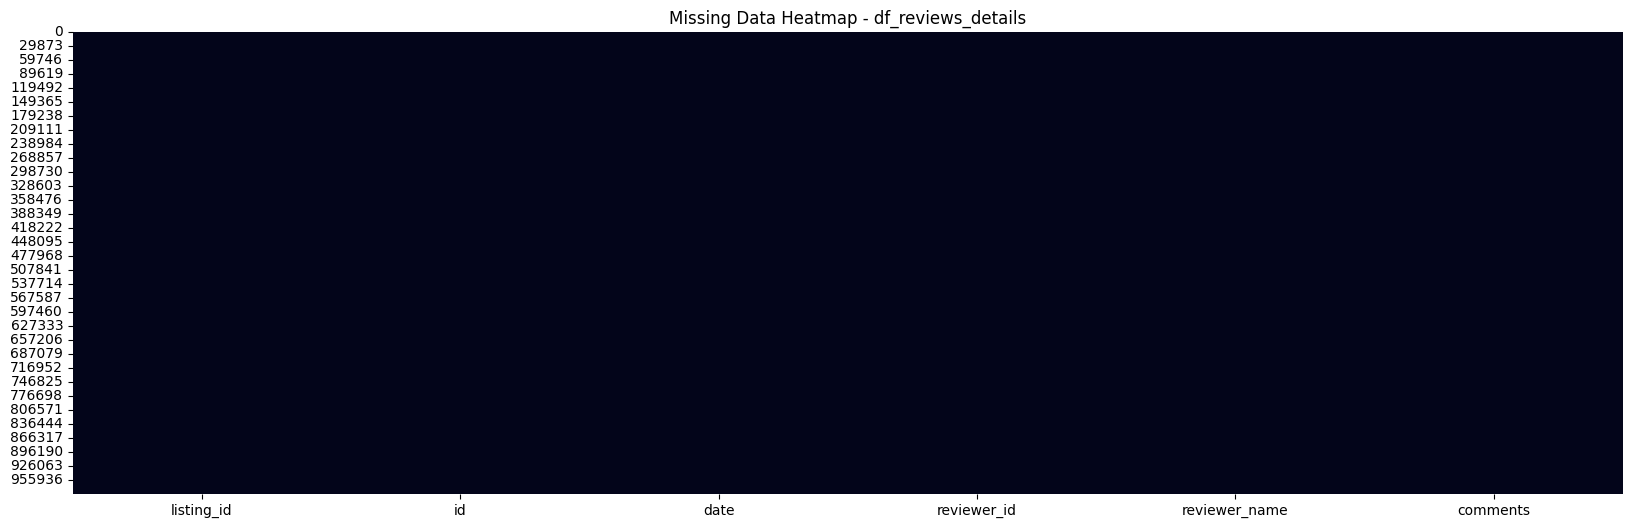

In [30]:
#Análisis de nulos:
plot_missing(df_reviews_details, "df_reviews_details")

In [31]:
report_missing(df_reviews_details)

,missing_count,missing_pct
comments,45,0.004565
reviewer_name,1,0.000101


Concluimos que el listado detallado de reviews no contiene un porcentaje significativo de nulos o faltantes, dado el muy bajo número de filas afectadas, se podría directamente descartarlas sin afectar el dataset en general.

<span style="font-size:24px; color:blue">Calendar</span>

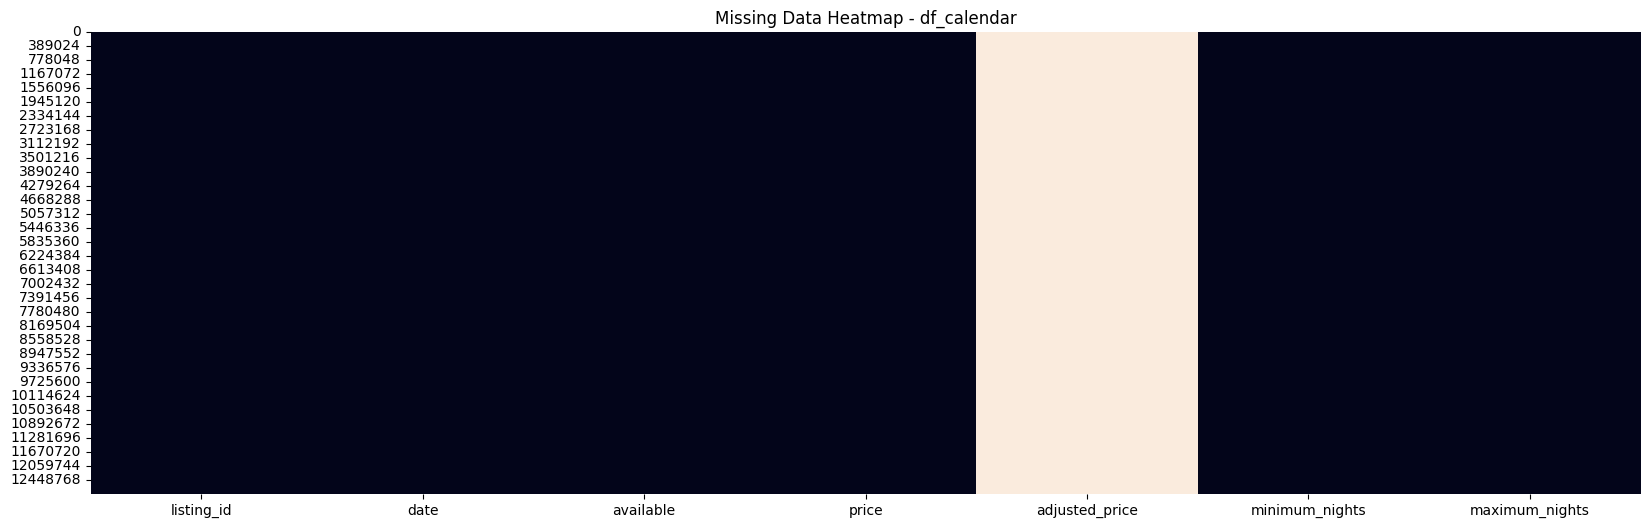

,missing_count,missing_pct
adjusted_price,12837777,100.000000
minimum_nights,14,0.000109
maximum_nights,14,0.000109


In [32]:
#análisis de nulos:
plot_missing(df_calendar, "df_calendar")
report_missing(df_calendar)

La columna adjusted_price fue incluida en la versión 2 del formato de este dataset, y no incluye descripción. Dado que tiene un 100% de datos faltantes, puede ser descartada.

### 2.2 Detección de outliers
Debido a los tipos de variables involucradas, sólo df_listing_details amerita analizar si contiene outliers, ya que contiene variables como precio, cantidad de días disponibles, habitaciones, etc. Como criterios utilizamos los siguientes umbrales:
- 1,5 * IQR 
- 3 * IQR como umbral de outliers severos
- 3 * desviación estándar

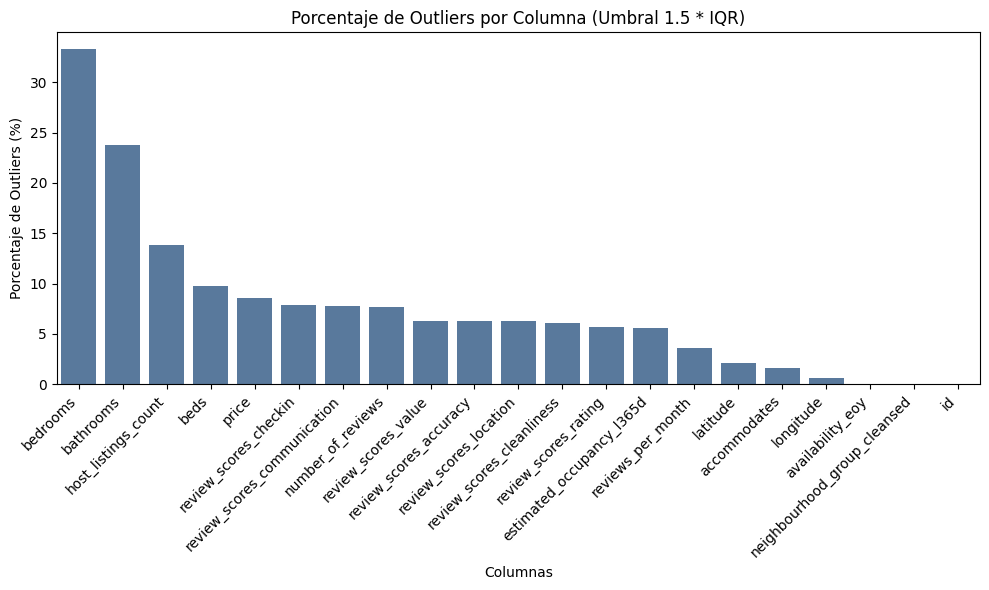

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,id,0.00,0.00,0.00
1,accommodates,1.58,0.55,1.58
2,bedrooms,33.31,33.31,0.84
3,beds,9.74,2.05,1.20
4,bathrooms,23.74,23.74,1.47
5,price,8.52,4.09,0.11
6,availability_eoy,0.00,0.00,0.00
7,estimated_occupancy_l365d,5.62,0.00,0.00
8,review_scores_rating,5.67,1.92,1.66
9,review_scores_accuracy,6.26,3.37,1.60


In [33]:
porcentaje_outliers_listings = detectar_outliers(df_listings_details_interes)
porcentaje_outliers_listings

Se observa que en general el porcentaje de valores atípicos es bajo, aunque hay variables como bathrooms, bedrooms que contienen un porcentaje elevado según el criterio de IQR, no así por el criterio de la desviación estándar, por lo que procedemos a analizarlos

In [34]:
df_listings_details_sorted_bathrooms = df_listings_details_interes.sort_values(by='bathrooms', ascending=False)
df_listings_details_sorted_bathrooms[['name', 'description', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_value']].head(20)

,name,description,bathrooms,bedrooms,beds,price,review_scores_value
4231,Apart Hotel León Imperial ubicado en Pasco 492.,An Apart Hotel located in the strategic center...,22.0,22.0,4.0,19000.0,3.71
29274,simple sencillo servicial,Everything you want to explore is steps away f...,20.0,19.0,30.0,17644.0,NaN
9251,Hotel Entero con terraza y piscina - Ideal Gru...,The First Palermo Hotel has 16 rooms and offe...,16.0,16.0,24.0,1372781.0,5.00
34936,Habitaciones privadas Gran terraza con parrilla,"When you open the door to this place, you'll f...",16.0,7.0,4.0,29406.0,NaN
24402,"15 departamentos, mismo edificio",Up to 30 people can enter 15 apartments in the...,15.0,15.0,15.0,1260260.0,NaN
9553,Ultra House Mansion-Edificio Diseño-palermo soho,Maximum 22 passengers <br />Due to its unique ...,13.0,11.0,11.0,1665340.0,4.52
20533,Entire group accommodation - Hostel,GROUP accommodation: up to 16 people.<br />EXC...,12.5,9.0,14.0,346572.0,4.25
24351,"10 departamentos, mismo edificio",Relax with the whole family in this quiet home.,10.0,10.0,10.0,1050217.0,NaN
7442,20 guests at 10 aparts same building,ATTENTION: THESE ARE 10 INDEPENDENT UNITS IN T...,10.0,10.0,10.0,324822.0,4.75
8144,Great house with garden ideal groups Palermo27...,Nina Suites is a lovely house located in the h...,9.5,9.0,22.0,705147.0,4.68


In [35]:
df_listings_details_sorted_bathrooms = df_listings_details_interes.sort_values(by='bedrooms', ascending=False)
df_listings_details_sorted_bathrooms[['name', 'description', 'bathrooms', 'bedrooms', 'beds','price', 'review_scores_value']].head(20)

,name,description,bathrooms,bedrooms,beds,price,review_scores_value
8876,Bed & Bike Buenos Aires,Bed & Bike Buenos Aires is the first accommoda...,NaN,35.0,NaN,NaN,NaN
32581,Epico Hotel Recoleta,The Recoleta neighborhood is the most sophisti...,1.0,31.0,2.0,73515.0,NaN
4231,Apart Hotel León Imperial ubicado en Pasco 492.,An Apart Hotel located in the strategic center...,22.0,22.0,4.0,19000.0,3.71
29935,Studio Standard,Strategic and unique location in front of the ...,1.0,20.0,1.0,51608.0,NaN
29274,simple sencillo servicial,Everything you want to explore is steps away f...,20.0,19.0,30.0,17644.0,NaN
31888,Esmeralda Smart Homes - Exclusivo para tu grupo,To note: By confirming this reservation they w...,9.0,18.0,18.0,630130.0,NaN
9251,Hotel Entero con terraza y piscina - Ideal Gru...,The First Palermo Hotel has 16 rooms and offe...,16.0,16.0,24.0,1372781.0,5.00
24345,Estupenda casa |Obelisco down town | Palacio Lima,"Awesome house , meters from the obelisk . <br ...",7.0,15.0,30.0,787663.0,5.00
24402,"15 departamentos, mismo edificio",Up to 30 people can enter 15 apartments in the...,15.0,15.0,15.0,1260260.0,NaN
11975,Espectacular casa en la Boca ! Palacio Lamadrid,Palacio Lamadrid is located in the mouth neigh...,5.0,14.0,32.0,787663.0,NaN


A priori, parecería que hay varios casos donde el valor atípico es incorrecto, ya que el precio es muy bajo con respecto al resto de las ofertas. Pero hay casos como el de id 9251 o 24401 donde aparentemente sí estarían alquilando una propiedad entera, y el número alto de habitaciones y baños es correcto. No siendo posible detectarlos únicamente por el número en sí, generamos variables de precio por cama/habitación/baño, y detectaremos los outliers de esta forma. Previamente, debemos filtar los outliers de precio, que arrojarían valores muy altos. Utilizamos el critero de 3 * std, que filtra aprox 0,11% de los valores

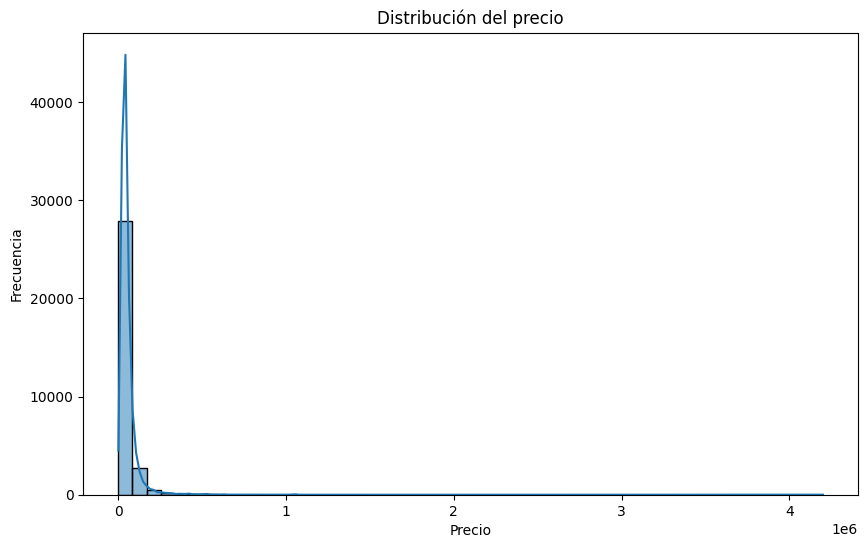

In [36]:
# Filtrar outliers de precio
# Calcular media y desviación estándar (umbral fijo de 3)
mean_price = df_listings_details_interes['price'].mean()
std_price = df_listings_details_interes['price'].std()
limite_inferior_price = mean_price - 3 * std_price
limite_superior_price = mean_price + 3 * std_price
df_listings_details_filtrado = df_listings_details_interes[
    (df_listings_details_interes['price'] >= limite_inferior_price) &
    (df_listings_details_interes['price'] <= limite_superior_price)
]

plt.figure(figsize=(10, 6))
sns.histplot(data=df_listings_details_filtrado, x='price', bins=50, kde=True)
plt.title('Distribución del precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Observamos que la distribución sigue teniendo valores muy elevados, por lo que procedemos a usar el criterio de 3 * IQR (filtra aprox 4% de los valores)

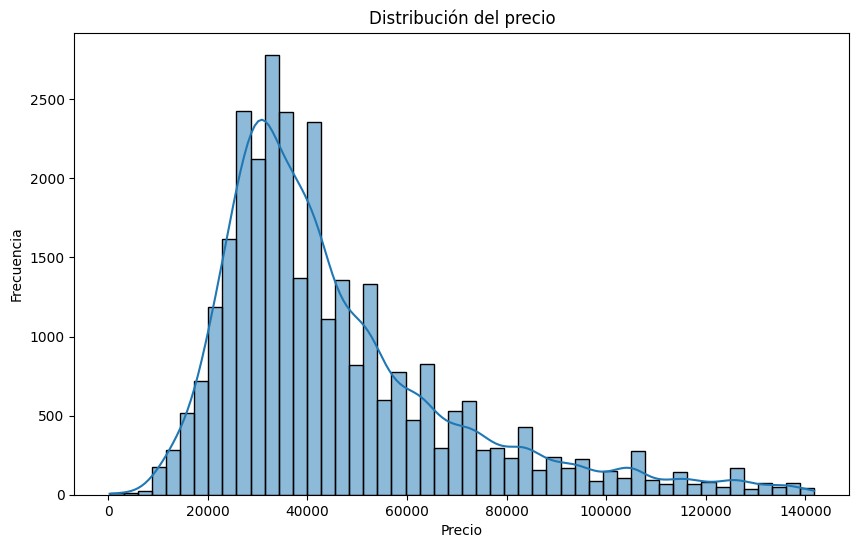

In [37]:
# Filtrar outliers de precio
# Utilizar criterio de 3 * IQR
Q1_price = df_listings_details_interes['price'].quantile(0.25)
Q3_price = df_listings_details_interes['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
limite_inferior_price = Q1_price - 3 * IQR_price
limite_superior_price = Q3_price + 3 * IQR_price
df_listings_details_filtrado = df_listings_details_interes[
    (df_listings_details_interes['price'] >= limite_inferior_price) &
    (df_listings_details_interes['price'] <= limite_superior_price)
]

plt.figure(figsize=(10, 6))
sns.histplot(data=df_listings_details_filtrado, x='price', bins=50, kde=True)
plt.title('Distribución del precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

C:\Users\alope\AppData\Local\Temp\ipykernel_3228\3970739547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_filtrado['precio_habitacion'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['bedrooms']
C:\Users\alope\AppData\Local\Temp\ipykernel_3228\3970739547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_filtrado['precio_cama'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['beds']
C:\Users\alope\AppData\Local\Tem

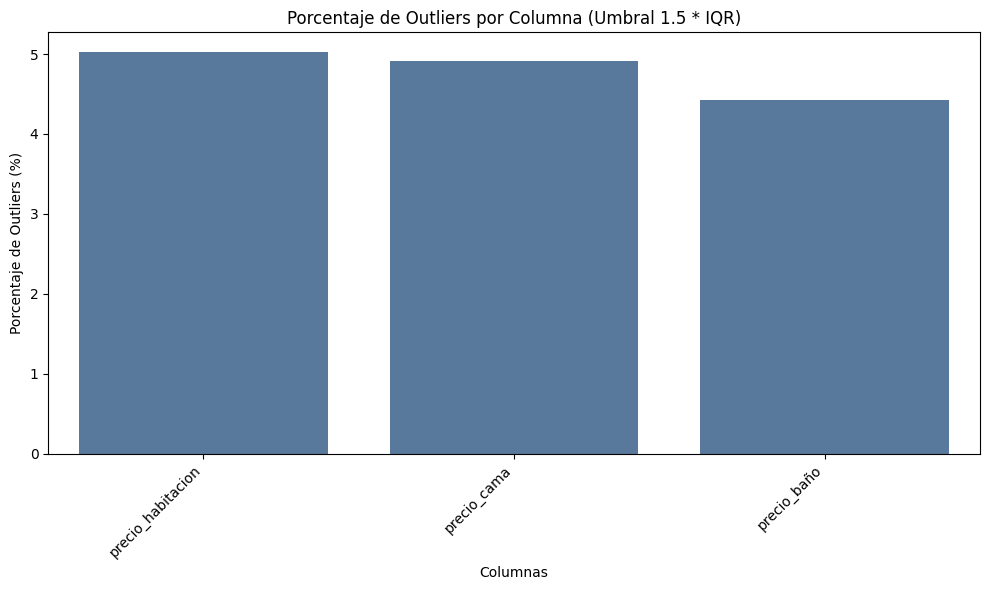

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,precio_habitacion,5.02,1.31,2.13
1,precio_cama,4.91,1.38,2.07
2,precio_baño,4.43,0.83,1.57


In [38]:
df_listings_details_filtrado['precio_habitacion'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['bedrooms']
df_listings_details_filtrado['precio_cama'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['beds']
df_listings_details_filtrado['precio_baño'] = df_listings_details_filtrado['price'] / df_listings_details_filtrado['bathrooms']

#Descartamos valores infinitos cuando cama, baño o habitacion es 0
df_listings_details_filtrado = df_listings_details_filtrado[(df_listings_details_filtrado['bedrooms'] !=0) & (df_listings_details_filtrado['beds'] !=0) & (df_listings_details_filtrado['bathrooms'] !=0)]

porcentaje_outliers_listings = detectar_outliers(df_listings_details_filtrado[['precio_habitacion', 'precio_cama', 'precio_baño']])
porcentaje_outliers_listings

In [39]:
df_listings_details_sorted_precio_habitacion = df_listings_details_filtrado.sort_values(by='precio_habitacion', ascending=True)
df_listings_details_sorted_precio_habitacion[['name', 'description', 'bathrooms', 'bedrooms', 'beds','price', 'precio_habitacion', 'precio_baño','review_scores_value']].head(20)

,name,description,bathrooms,bedrooms,beds,price,precio_habitacion,precio_baño,review_scores_value
893,Loft in Downtown - Best location!,LOFT (50m²) located in the CENTER OF BUENOS AI...,1.0,1.0,1.0,260.0,260.000000,260.000000,5.00
3116,"Designer Studio in Belgrano, 5 blocks to Subway",Only 5 blocks from Subway D (José Hernández). ...,1.0,1.0,2.0,600.0,600.000000,600.000000,4.33
28561,Alquiler cuartos en Gran casa,"Great house in Palermo, very well located. Wit...",5.0,14.0,14.0,11762.0,840.142857,2352.400000,NaN
4231,Apart Hotel León Imperial ubicado en Pasco 492.,An Apart Hotel located in the strategic center...,22.0,22.0,4.0,19000.0,863.636364,863.636364,3.71
29274,simple sencillo servicial,Everything you want to explore is steps away f...,20.0,19.0,30.0,17644.0,928.631579,882.200000,NaN
16805,Habitación con baño privado,"Enjoy the simplicity of this quiet, central ho...",1.5,2.0,2.0,2028.0,1014.000000,1352.000000,NaN
1318,Sunny apartment in BA,The apartment has multiple choices to go downt...,1.0,1.0,1.0,1065.0,1065.000000,1065.000000,4.90
33453,Habitación privada | Casa compartida | Palermo,"A shared house in the heart of Palermo, with 1...",3.0,11.0,1.0,11762.0,1069.272727,3920.666667,1.00
1391,Depto 2 Amb a un paso Microcentro,"Comfortable, modernized apartment, in the old ...",1.5,1.0,2.0,1149.0,1149.000000,766.000000,4.71
21548,Private room in shared house | Palermo,"A shared house in the heart of Palermo, with 1...",3.0,11.0,1.0,13800.0,1254.545455,4600.000000,NaN


In [40]:
df_listings_details_sorted_precio = df_listings_details_filtrado.sort_values(by='precio_cama', ascending=True)
df_listings_details_sorted_precio[['name', 'description', 'bathrooms', 'bedrooms', 'beds','price', 'precio_habitacion', 'precio_baño','review_scores_value']].head(20)

,name,description,bathrooms,bedrooms,beds,price,precio_habitacion,precio_baño,review_scores_value
893,Loft in Downtown - Best location!,LOFT (50m²) located in the CENTER OF BUENOS AI...,1.0,1.0,1.0,260.0,260.000000,260.000000,5.00
3116,"Designer Studio in Belgrano, 5 blocks to Subway",Only 5 blocks from Subway D (José Hernández). ...,1.0,1.0,2.0,600.0,600.000000,600.000000,4.33
1391,Depto 2 Amb a un paso Microcentro,"Comfortable, modernized apartment, in the old ...",1.5,1.0,2.0,1149.0,1149.000000,766.000000,4.71
29274,simple sencillo servicial,Everything you want to explore is steps away f...,20.0,19.0,30.0,17644.0,928.631579,882.200000,NaN
34594,hotel de mochileros,Discover the local gems from this modern home.,3.5,1.0,21.0,15239.0,15239.000000,4354.000000,NaN
6030,"Zona turística Shared Dormitory, Men only #Pod...","Shared rooms with modern and youthful design, ...",2.5,1.0,14.0,11101.0,11101.000000,4440.400000,4.22
28561,Alquiler cuartos en Gran casa,"Great house in Palermo, very well located. Wit...",5.0,14.0,14.0,11762.0,840.142857,2352.400000,NaN
28081,Cama en habitación mixta de 12 personas,Lead Hostel stands out for its excellent locat...,4.0,1.0,12.0,11796.0,11796.000000,2949.000000,5.00
12075,Habitación privada a 15 minutos del obelisco!,Palacio Lamadrid is a beautiful and traditiona...,5.0,1.0,16.0,15753.0,15753.000000,3150.600000,4.57
4465,Ph en Villa Del Parque 3 ambientes +4 huspedes,PH House type apartment on two floors. PB livi...,1.0,2.0,4.0,4051.0,2025.500000,4051.000000,4.66


Observamos que ahora los porcentajes de outliers son menores. Dado que aún hay entremezclados datos válidos con datos erróneos, por el momento únicamente eliminaremos los outliers de precio, con un umbral de 3 *IQR

In [41]:
def eliminar_outliers(df, columns=None):
    """
    Elimina outliers en columnas numéricas especificadas de un DataFrame usando el criterio de 3 * IQR.
    Genera un gráfico de barras ordenado por el porcentaje de valores eliminados por columna usando Seaborn.
    
    Parameters:
    df (pd.DataFrame): DataFrame de entrada.
    columns (list, optional): Lista de columnas numéricas a analizar. Si es None, se usan todas las columnas numéricas.
    
    Returns:
    tuple: (pd.DataFrame limpio sin outliers, pd.DataFrame con reporte de porcentajes de valores eliminados por columna,
            float con el porcentaje de filas que permanecen en el dataset)
    """
    # Crear una copia del DataFrame para no modificar el original
    df_clean = df.copy()
    
    # Seleccionar columnas numéricas
    all_numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    # Si no se especifican columnas, usar todas las numéricas; de lo contrario, validar las columnas proporcionadas
    if columns is None:
        columnas_numericas = all_numeric_cols
    else:
        # Verificar que las columnas proporcionadas existan y sean numéricas
        columnas_numericas = [col for col in columns if col in all_numeric_cols]
        if not columnas_numericas:
            raise ValueError("Ninguna de las columnas especificadas es numérica o existe en el DataFrame")
        if len(columnas_numericas) < len(columns):
            print(f"Advertencia: Algunas columnas especificadas no son numéricas o no existen: {set(columns) - set(columnas_numericas)}")
    
    results = []
    
    # Almacenar índices de filas a conservar (inicialmente todas)
    indices_to_keep = set(df_clean.index)

    for col in columnas_numericas:
        # Calcular IQR
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Límites para IQR con umbral 3 (outliers severos)
        limite_inferior_iqr_3 = Q1 - 3 * IQR
        limite_superior_iqr_3 = Q3 + 3 * IQR

        # Identificar outliers
        outliers_iqr_3 = df_clean[(df_clean[col] < limite_inferior_iqr_3) | (df_clean[col] > limite_superior_iqr_3)]
        
        # Calcular porcentaje de valores eliminados
        total_data_points = len(df_clean[col].dropna())
        outlier_percentage_iqr_3 = (len(outliers_iqr_3) / total_data_points) * 100 if total_data_points > 0 else 0
        
        # Guardar resultados
        results.append({
            'Columna': col,
            'Porcentaje Valores Eliminados (Umbral 3 * IQR)': round(outlier_percentage_iqr_3, 2)
        })
        
        # Actualizar índices a conservar (excluir outliers)
        indices_to_keep = indices_to_keep.intersection(set(df_clean[~((df_clean[col] < limite_inferior_iqr_3) | (df_clean[col] > limite_superior_iqr_3))].index))

    # Filtrar el DataFrame para conservar solo las filas sin outliers en las columnas seleccionadas
    df_clean = df_clean.loc[list(indices_to_keep)]
    
    # Calcular el porcentaje de filas que permanecen
    total_filas_original = len(df)
    total_filas_limpio = len(df_clean)
    porcentaje_filas_permanecen = (total_filas_limpio / total_filas_original) * 100 if total_filas_original > 0 else 0

    # Convertir resultados a DataFrame
    result_df = pd.DataFrame(results)
    
    # Ordenar por porcentaje de valores eliminados de mayor a menor
    result_df_sorted = result_df.sort_values(by='Porcentaje Valores Eliminados (Umbral 3 * IQR)', ascending=False)
    
    # Generar gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=result_df_sorted,
        x='Columna',
        y='Porcentaje Valores Eliminados (Umbral 3 * IQR)',
        color='#4e79a7'  # Azul oscuro compatible con temas claros y oscuros
    )
    plt.title('Porcentaje de Valores Eliminados por Columna (Umbral 3 * IQR)')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Valores Eliminados (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df_clean, result_df, porcentaje_filas_permanecen

C:\Users\alope\AppData\Local\Temp\ipykernel_3228\3316728919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes['precio_habitacion'] = df_listings_details_interes['price'] / df_listings_details_interes['bedrooms']
C:\Users\alope\AppData\Local\Temp\ipykernel_3228\3316728919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes['precio_cama'] = df_listings_details_interes['price'] / df_listings_details_interes['beds']
C:\Users\alope\AppData\Local\Temp\ipyk

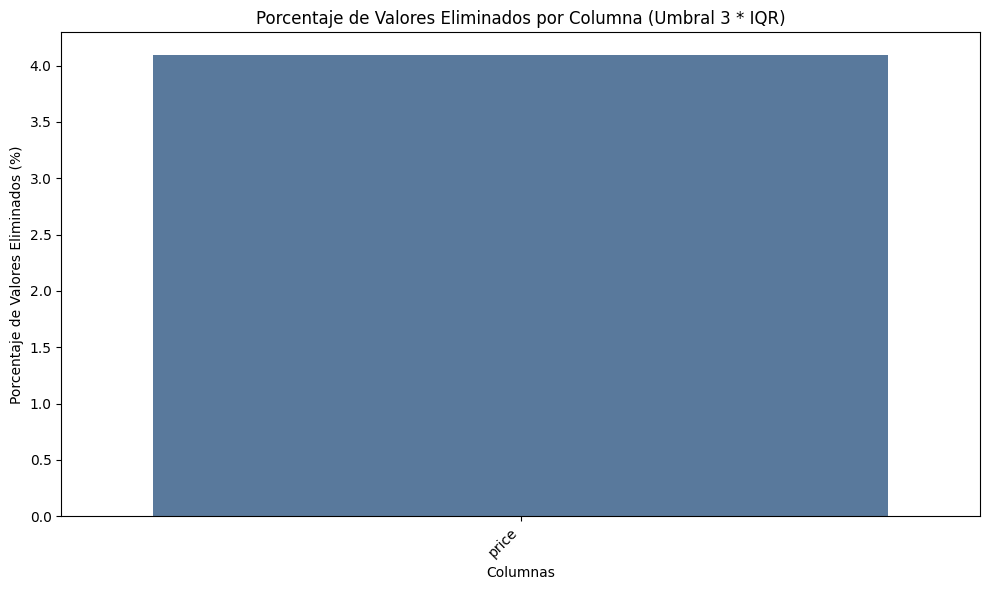

El porcentaje de filas que permanecen en el  dataset es 96.32%


In [42]:
#Generamos las columnas en el df original
df_listings_details_interes['precio_habitacion'] = df_listings_details_interes['price'] / df_listings_details_interes['bedrooms']
df_listings_details_interes['precio_cama'] = df_listings_details_interes['price'] / df_listings_details_interes['beds']
df_listings_details_interes['precio_baño'] = df_listings_details_interes['price'] / df_listings_details_interes['bathrooms']

df_listings_limpio, resultados, porcentaje_filas_permanecen  = eliminar_outliers(df_listings_details_interes, columns=['price'])
print(f"El porcentaje de filas que permanecen en el  dataset es {porcentaje_filas_permanecen:.2f}%")

## 3. Visualización y análisis de variables del dataset

### 3.1 Análisis de variables categóricas

#### Tipo de propiedad

In [80]:
# Analizamos los tipos de propiedades 
print(df_listings_limpio['property_type'].unique())
print(df_listings_limpio['property_type'].nunique())

['Entire condo' 'Entire rental unit' 'Private room in rental unit'
 'Entire loft' 'Entire serviced apartment' 'Private room in home'
 'Entire home' 'Entire townhouse' 'Private room in bed and breakfast'
 'Camper/RV' 'Entire guest suite' 'Private room'
 'Private room in guesthouse' 'Private room in villa'
 'Private room in condo' 'Private room in townhouse' 'Entire place'
 'Private room in hostel' 'Private room in serviced apartment'
 'Room in hostel' 'Casa particular' 'Shared room in villa'
 'Private room in chalet' 'Entire guesthouse' 'Entire vacation home'
 'Room in boutique hotel' 'Entire bungalow' 'Tiny home'
 'Private room in loft' 'Private room in casa particular'
 'Room in serviced apartment' 'Room in hotel' 'Shared room in hostel'
 'Private room in guest suite' 'Entire home/apt'
 'Shared room in rental unit' 'Room in aparthotel' 'Entire in-law'
 'Room in bed and breakfast' 'Shared room in loft' 'Shared room in home'
 'Entire cabin' 'Private room in religious building' 'Castle'


Tenemos 66 tipos de alojamientos distintos, lo cual puede llegar a atomizar el análisis. Como alternativa, en base al texto podríamos clasificar aquellos que indican "private room", "shared room", "entire" (por la propiedad entera), y "otros para el resto. Antes analizamos las cantidades de cada tipo:

In [81]:
df_listings_limpio['property_type'].value_counts()

property_type
Entire rental unit             24725
Entire condo                    3500
Private room in rental unit     1170
Entire serviced apartment       1070
Private room in home             777
                               ...  
Bus                                1
Entire home/apt                    1
Pension                            1
Private room in dome               1
Shared room in condo               1
Name: count, Length: 66, dtype: int64

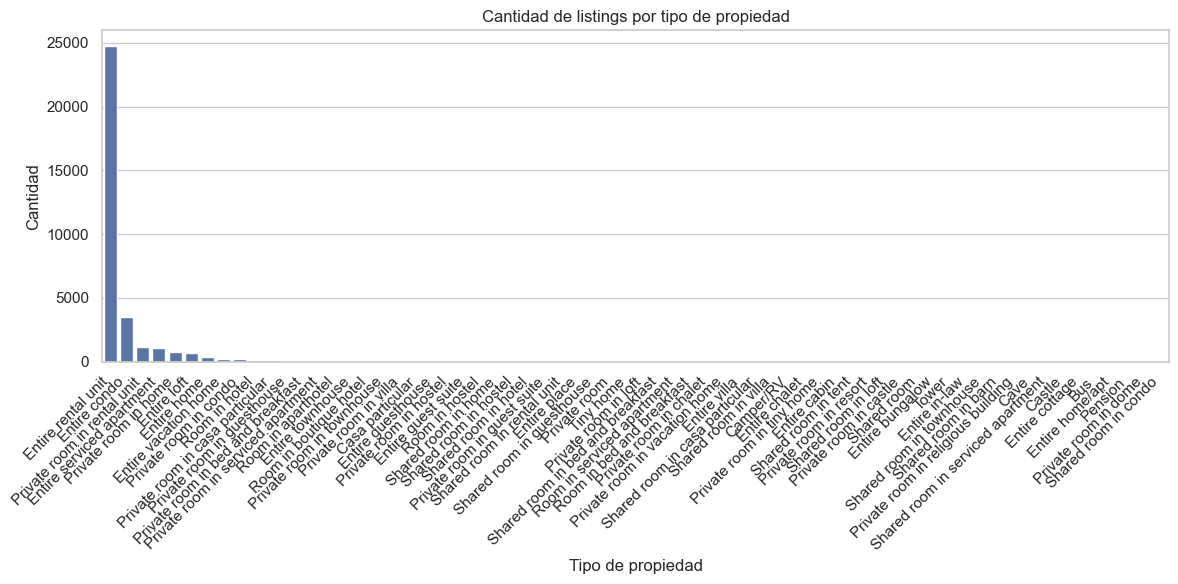

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener conteo de cada tipo de propiedad
counts = df_listings_limpio['property_type'].value_counts()

# Convertir a DataFrame para usar con seaborn
counts_df = counts.reset_index()
counts_df.columns = ['property_type', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=counts_df, x='property_type', y='count')
plt.title('Cantidad de listings por tipo de propiedad')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Vemos que "Entire rental unit" es la mayor parte de las unidades, seguido de "Entire condo". Esto puede implicar no tener suficientes datos para el resto de las categorías para analizar. Debido a esto, al momento de analizar esta variable se crearon categorías específicas para poder agruparlas (esto se realiza en el punto 4)

#### Tipo de habitación

Analizamos la cantidad de listings por tipo de habitación:

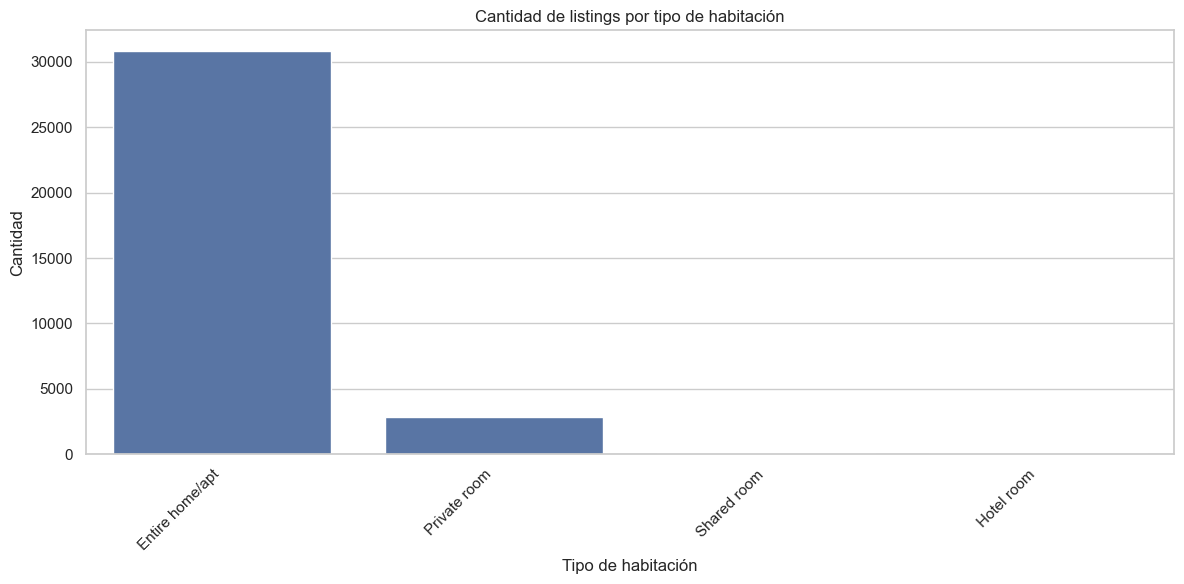

In [89]:
counts_room_type = df_listings_limpio['room_type'].value_counts()

# Convertir a DataFrame para usar con seaborn
counts_room_type_df = counts_room_type.reset_index()
counts_room_type_df.columns = ['room_type', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=counts_room_type_df, x='room_type', y='count')
plt.title('Cantidad de listings por tipo de habitación')
plt.xlabel('Tipo de habitación')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

En este caso, se observa una menor cantidad de categorías, aunque hay un desbalance evidente en Entire home vs el resto

#### Barrio

Analizamos la cantidad de listings por barrio:

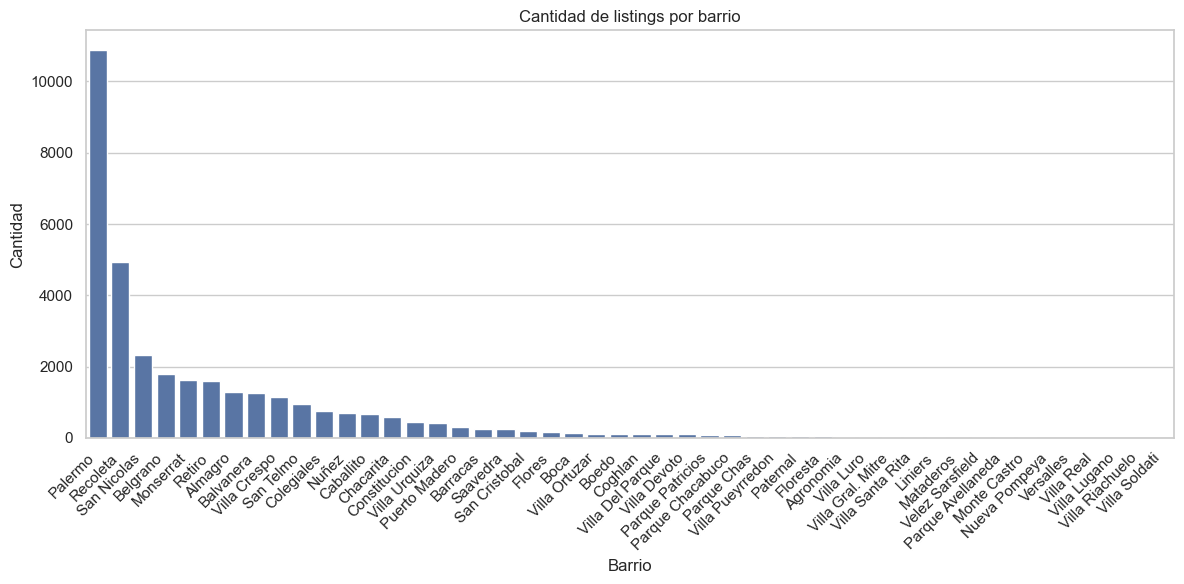

In [90]:
counts = df_listings_limpio['neighbourhood_cleansed'].value_counts()

# Convertir a DataFrame para usar con seaborn
counts_df = counts.reset_index()
counts_df.columns = ['Barrio', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=counts_df, x='Barrio', y='count')
plt.title('Cantidad de listings por barrio')
plt.xlabel('Barrio')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Se observa que Palermo tiene la mayor cantidad de listings con bastante diferencia de Recoleta, que es el segundo. La mayor cantidad de listings se encuentra concentrado en unos pocos barrios

### 3.2 Análisis de variables numéricas

#### Distribución de listings por cantidad de dormitorios

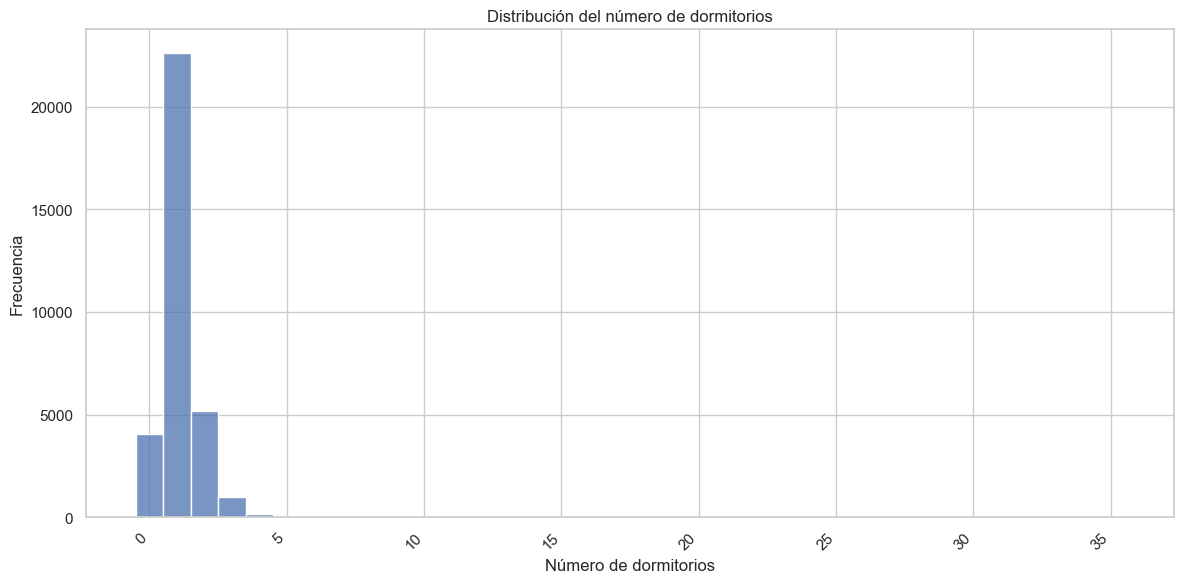

In [91]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_listings_limpio, x='bedrooms', discrete=True)
plt.title("Distribución del número de dormitorios")
plt.xlabel("Número de dormitorios")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Ampliamos de 4 habitaciones en adelante, ya que no observan las cantidades por ser bajas

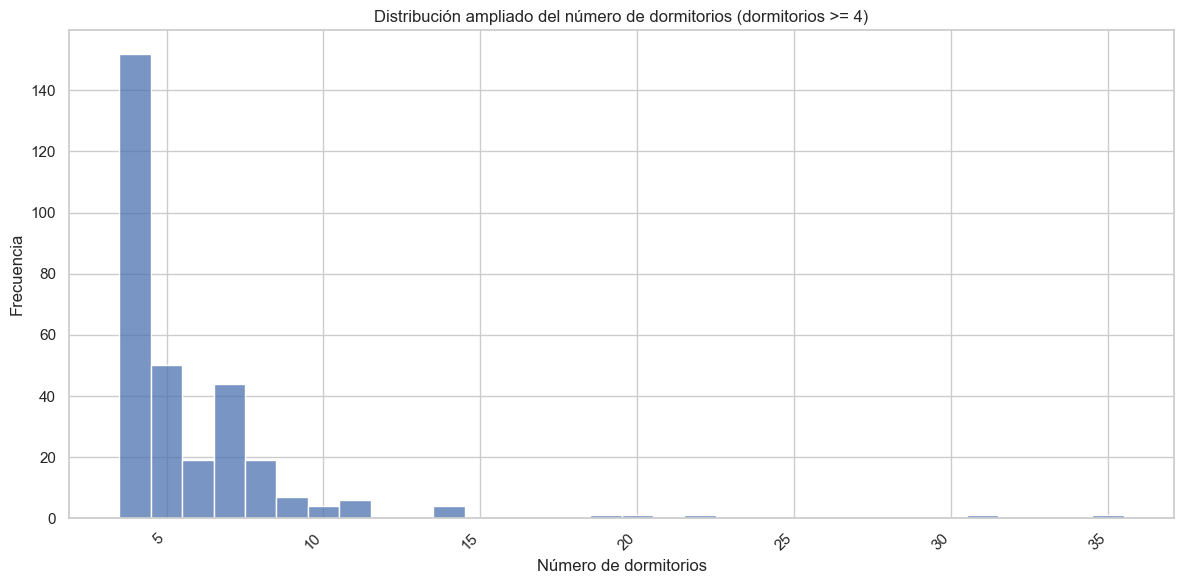

In [94]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_listings_limpio[df_listings_limpio['bedrooms'] >= 4], x='bedrooms', discrete=True)
plt.title("Distribución ampliado del número de dormitorios (dormitorios >= 4)")
plt.xlabel("Número de dormitorios")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Se observa que hay menor cantidad de listings con 5 habitaciones en adelante. La mayoría de los listings están concentrados en propiedades 1 habitación. Se observa también que la cola de la distribución es larga, ya que hay algunas pocas propiedades listadas con hasta 35 habitaciones. Durante el análisis de outliers, comprobamos que algunos de estos listings son genuinos, ya que alquilan propiedades completas donde en la descripción indica que cuenta con esa cantidad de habitaciones

#### Distribución de listings por número de camas

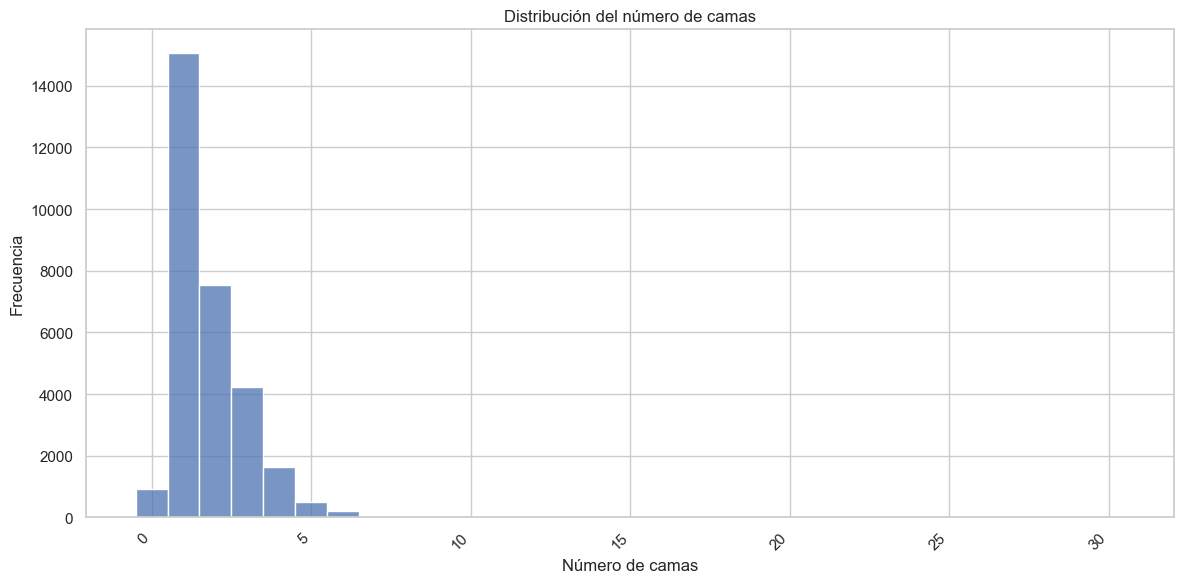

In [95]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_listings_limpio, x='beds', discrete=True)
plt.title("Distribución del número de camas")
plt.xlabel("Número de camas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Nuevamente, ampliamos el gráfico para observar la cantidad de listings con mayor cantidad de camas (en este caso >=5)

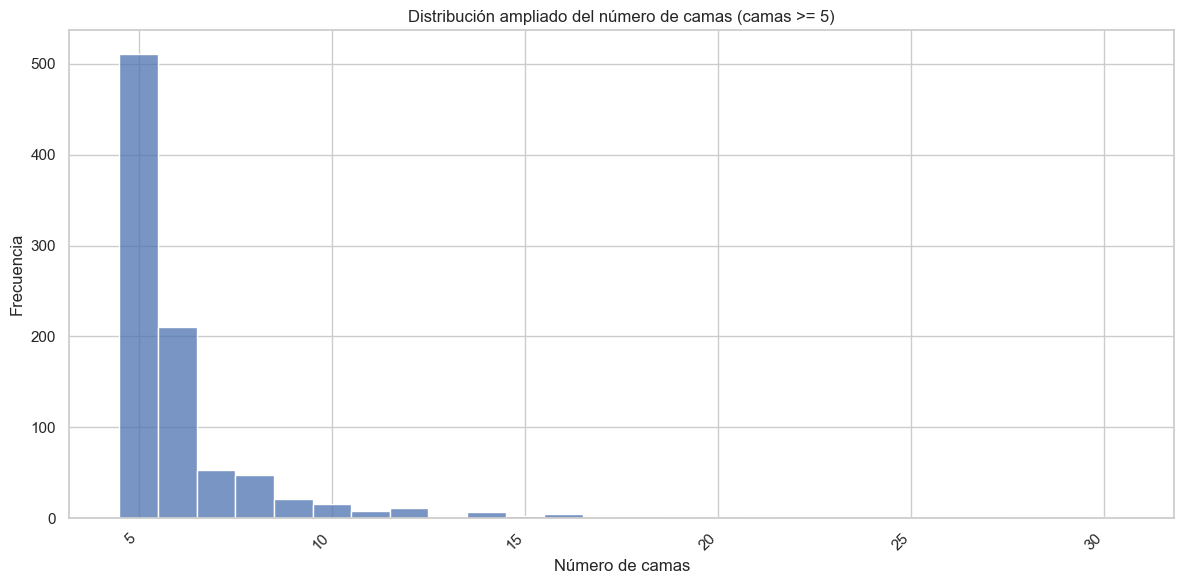

In [96]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_listings_limpio[df_listings_limpio['beds'] >= 5], x='beds', discrete=True)
plt.title("Distribución ampliado del número de camas (camas >= 5)")
plt.xlabel("Número de camas")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

La distribución es similar a la del número de habitaciones, estando concentrada la mayor cantidad de listings en 1 cama, y disminuyendo significativamente a partir de un valor, aunque en este caso es 6 camas mientras que para habitaciones disminuía a partir de 5

#### Distribución de ocupación a final de año

Analizamos la variable availability_eoy, que representa la cantidad de días que la propiedad estuvo disponible al final del año

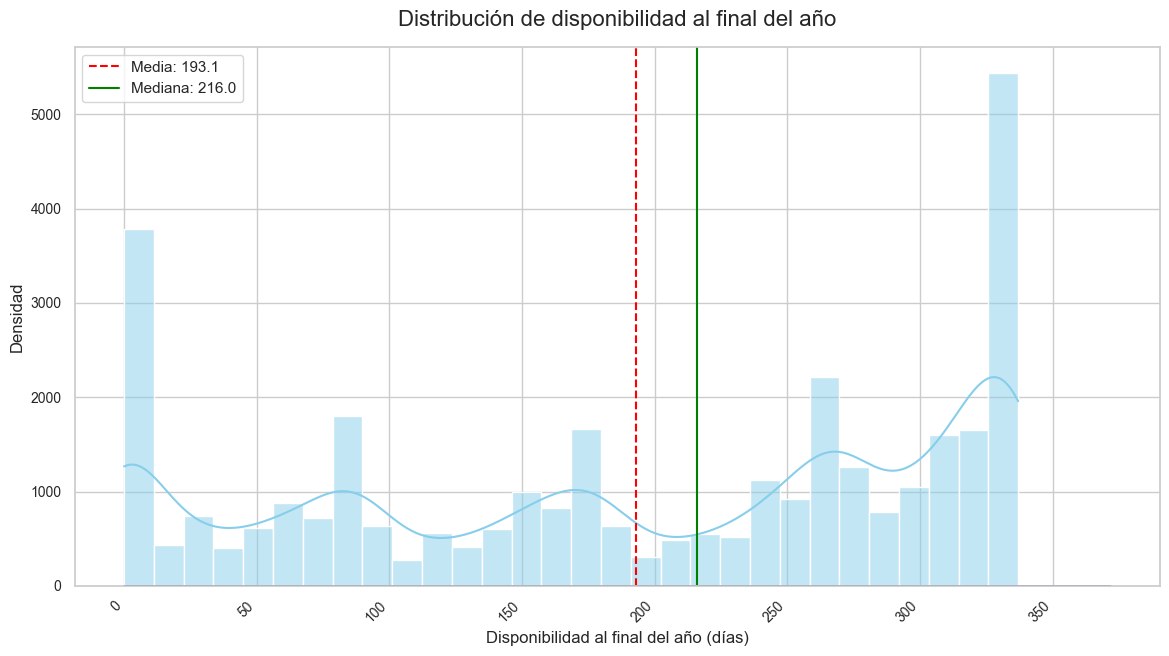

In [104]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7)) 

# Crear distribución e histograma
sns.histplot(data=df_listings_limpio, x='availability_eoy', kde=True, 
             color='skyblue', alpha=0.5, bins=30)  
sns.kdeplot(data=df_listings_limpio, x='availability_eoy', color='navy', linewidth=2, 
            bw_adjust=0.8, clip=(0, None))  

# Agregar línea de media y mediana
mean_val = df_listings_limpio['availability_eoy'].mean()
median_val = df_listings_limpio['availability_eoy'].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.1f}')

plt.title("Distribución de disponibilidad al final del año", fontsize=16, pad=15)
plt.xlabel("Disponibilidad al final del año (días)", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.legend()

In [102]:
print(f"Valor mínimo de availability_eoy: {df_listings_limpio['availability_eoy'].min()}")
print(f"Valor máximo de availability_eoy: {df_listings_limpio['availability_eoy'].max()}")

Valor mínimo de availability_eoy: 0
Valor máximo de availability_eoy: 337


Observamos que hay una gran cantidad de valores centrados en 0, lo que implica ocupación total, y un pico más alto centrado en aprox 340 días, que implica que la propiedad estuvo disponible la mayor parte de los 365 días del año. La media es de 193 días, que implica una disponibilidad de 53%, y la mediana de 216 días, que implica disponibilidad de 59%.

#### Relación entre el precio y la disponibilidad

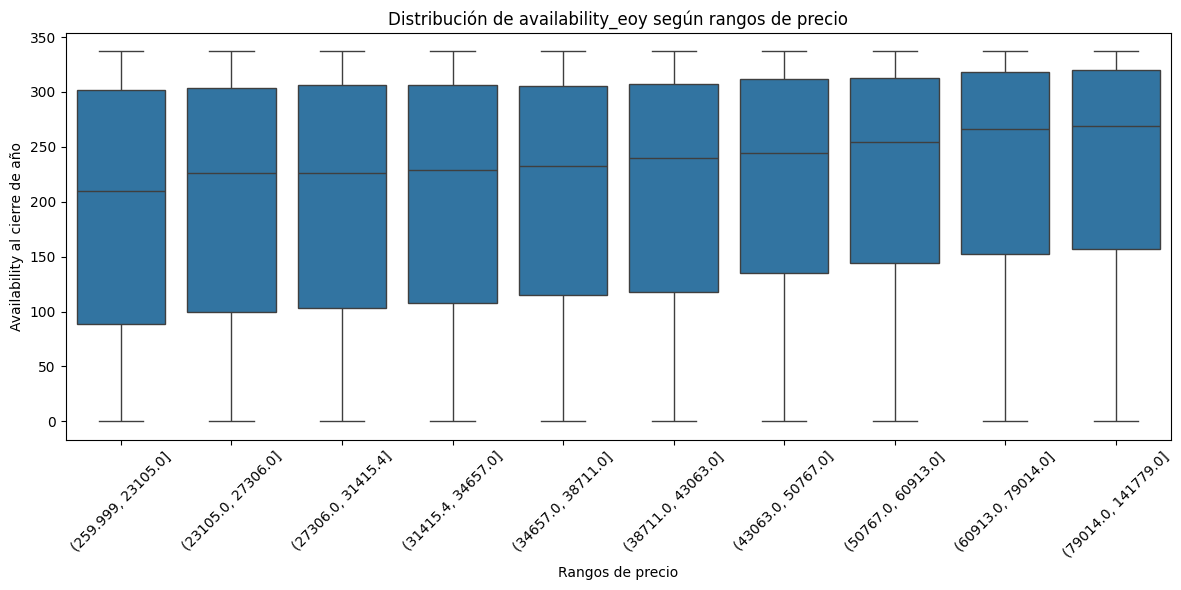

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
# Crear bins de precio (podés ajustar la cantidad de bins)
df_listings_limpio['price_bin'] = pd.qcut(df_listings_limpio['price'], q=10, duplicates='drop')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings_limpio, x='price_bin', y='availability_eoy')
plt.xticks(rotation=45)
plt.title("Distribución de availability_eoy según rangos de precio")
plt.xlabel("Rangos de precio")
plt.ylabel("Availability al cierre de año")
plt.tight_layout()
plt.show()

Si bien hay bastante solapamiento en los boxplot, en rangos de precios más altos, la disponibilidad al final del año es mayor, por lo que el pricing es una estrategia importante para lograr ocupar la propiedad

#### Correlograma

Generamos un correlograma entre las variables numéricas. Dado que las variables están en distintas escalas (por ej rating en una escala de 5, y availability_eoy va de 0 a 365), usamos el coeficiente de correlación de spearman, que toma la correlación entre rangos y muestra si las variables crecen o decrecen juntas independiemente de si la relación es lineal

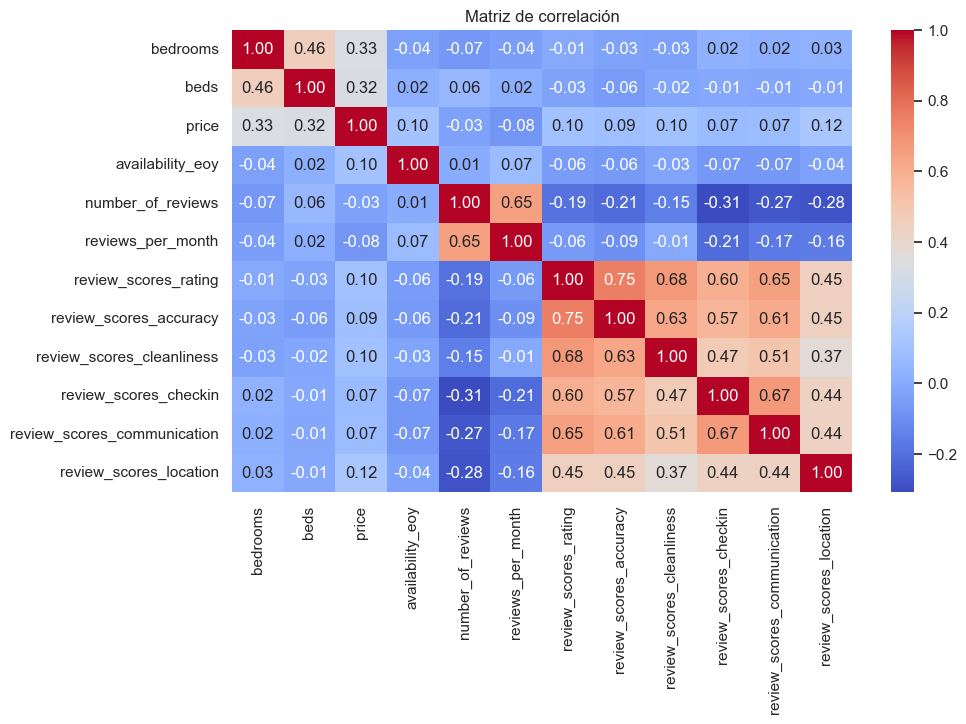

In [108]:
columnas_corr = ['bedrooms', 'beds', 'price', 'availability_eoy', 'number_of_reviews', 'reviews_per_month', 
                 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                 'review_scores_communication', 'review_scores_location']

plt.figure(figsize=(10, 6))
sns.heatmap(df_listings_limpio[columnas_corr].corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()



Se oberva que:
- El precio tiene una correlación muy débil con el número de camas y habitaciones. Esto puede indicar que hay algo que influye de forma mayor en el precio, por ej. el barrio. No obstante, no tiene correlación tampoco con el score de review de locación
- El score de reviews general (review_scores_rating), está correlacionado principalmente con accuray, comunicación y limpieza, y tiene una correlación baja con el score de locación, lo que indica que es un factor de menor impacto que el resto en la review general

## 4. Preguntas

### 4.1 ¿Cuál es la relación entre el precio de las propiedades y su tipo de alojamiento?

De acuerdo a lo mencionado en el punto 3 con respecto a la cantidad de tipos de propiedades que tenemos, creamos una columna 'property_type_summary', donde mantenemos los dos primeros tipos, y agrupamos el resto

In [47]:
def clasificar_alojamiento(row):
    tipo = row['property_type'].lower()
    if 'entire rental unit' in tipo:
        return 'entire_rental_unit'
    elif 'entire condo' in tipo:
        return 'entire_condo'
    elif 'shared room' in tipo:
        return 'habitacion_compartida'
    elif 'private room' in tipo:
        return 'habitacion_privada'
    elif 'entire' in tipo:
        return 'propiedad_completa_otros'
    else:
        return 'otros'

df_listings_limpio['property_type_summary'] = df_listings_limpio.apply(clasificar_alojamiento, axis =1)

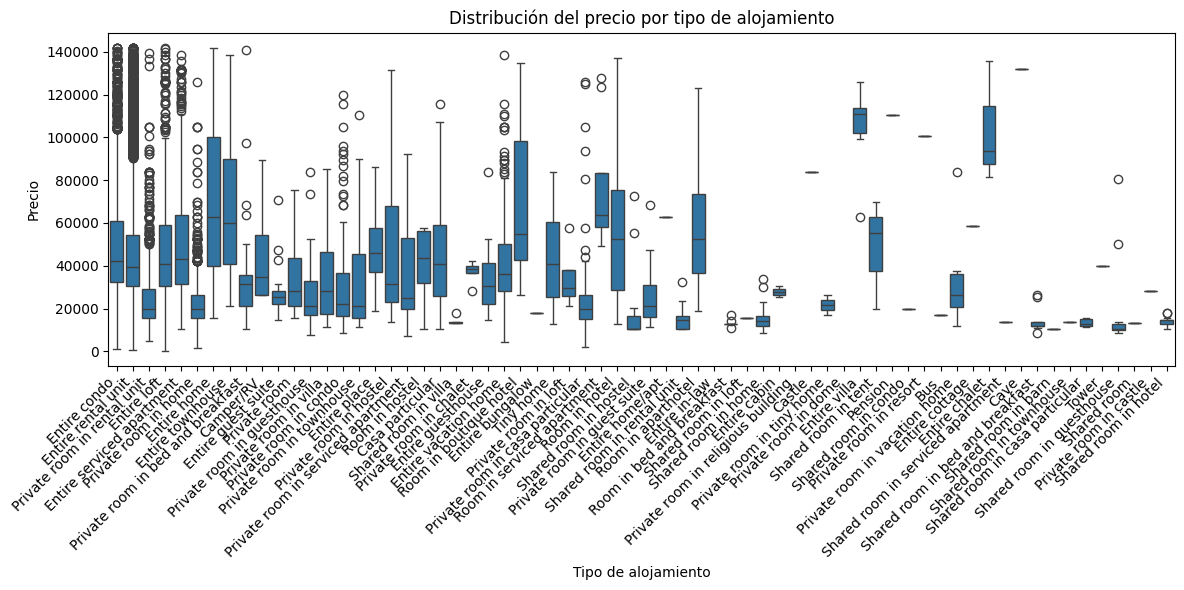

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings_limpio, x='property_type', y='price')
plt.title('Distribución del precio por tipo de alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Si bien se observan valores de boxplot más bajos, la cantidad de tipos de propiedades dificulta el análisis. Utilizamos el tipo de propiedad simplificado

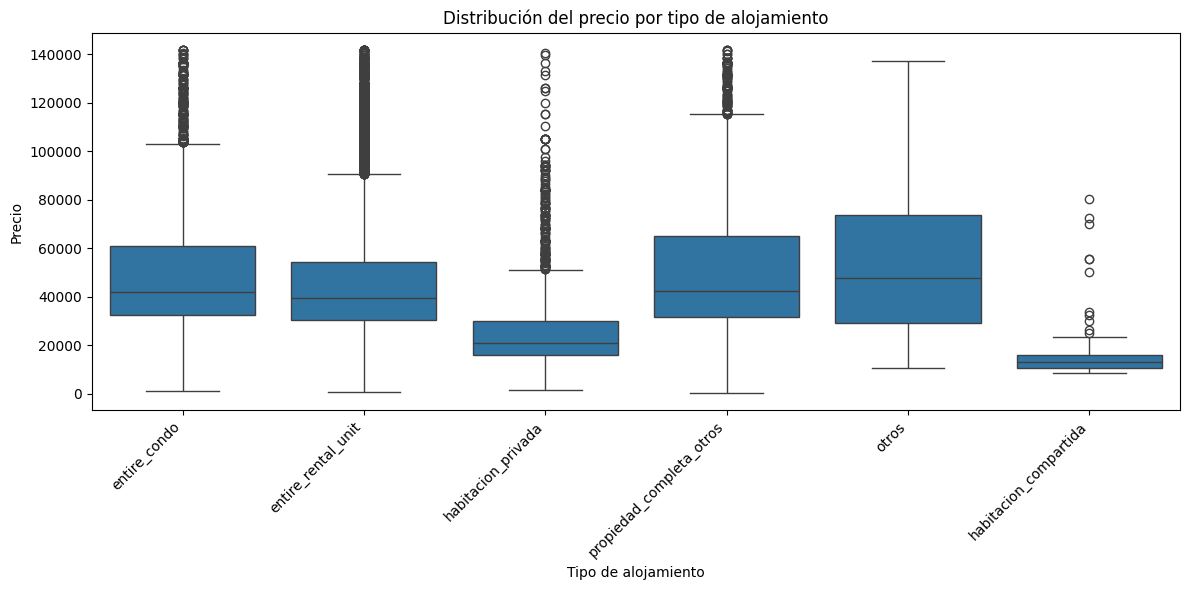

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings_limpio, x='property_type_summary', y='price')
plt.title('Distribución del precio por tipo de alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Utilizamos la columna de tipo de habitación ya presente en el dataset

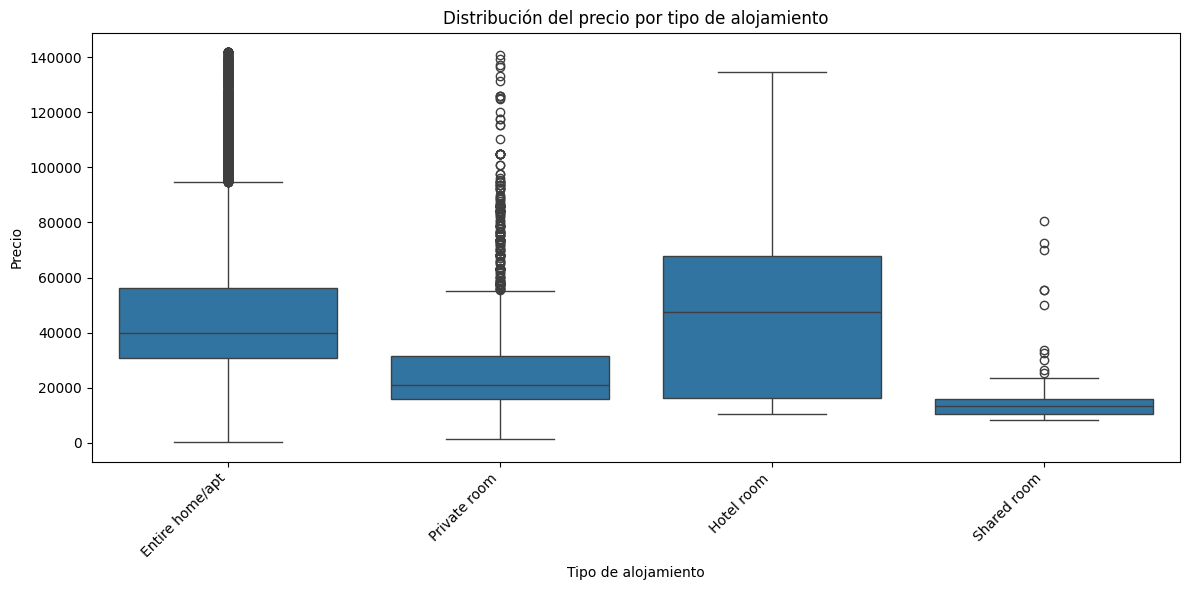

In [50]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings_limpio, x='room_type', y='price')
plt.title('Distribución del precio por tipo de alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Ahora sí observamos que:
- La habitación compartida tiene el precio más bajo en general
- La habitación privada tiene un precio algo más elevado al de la habitación compartida, pero menor al resto de los tipos de alojamiento. No obstante, tiene varios valores por encima que figuran como outliers
- El valor de la propiedad completa es más alto en general que el de habitación privada y compartida
- Para habitación de hotel, la mediana es alta, pero el box plot muestra que el rango de precios es amplio

### 4.2 ¿Existen patrones de ocupación según la ubicación?

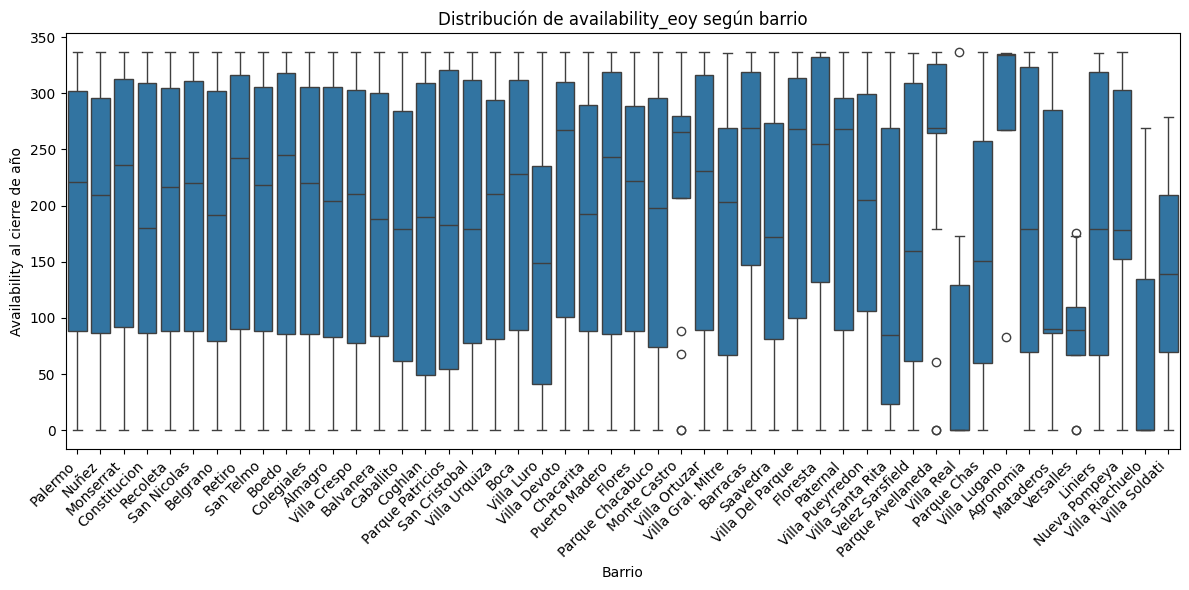

In [51]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings_limpio, x='neighbourhood_cleansed', y='availability_eoy')
plt.xticks(rotation=45)
plt.title("Distribución de availability_eoy según barrio")
plt.xlabel("Barrio")
plt.ylabel("Availability al cierre de año")
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

No se observa un patrón claro. Algunos barrios como Villa Luro, Villa Santa Rita o Mataderos registran un valor de disponibilidad al cierre del año menor

### 4.3 ¿Cómo varía la disponibilidad de las propiedades según el número de camas y habitaciones?

Graficamos el promedio de disponibilidad al final del año de acuerdo al número de habitaciones. Ya habíamos comprobado durante el análisis de la variable que la cantidad de listings disminuía significativamente a partir de 5 habitaciones en adelante

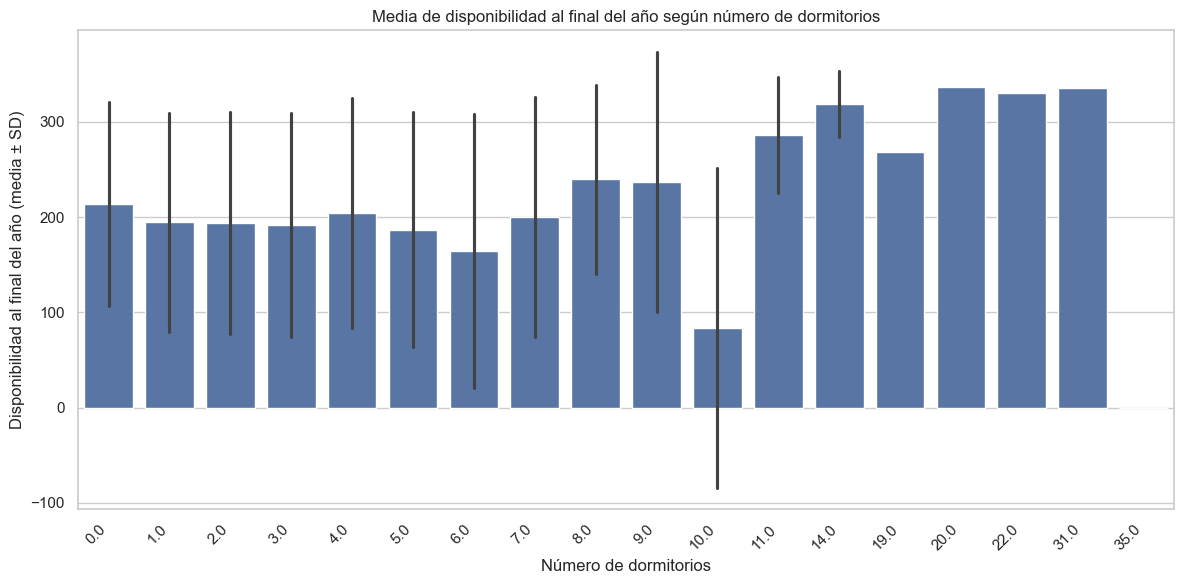

In [93]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_listings_limpio, x='bedrooms', y='availability_eoy', estimator='mean', errorbar='sd')
plt.title("Media de disponibilidad al final del año según número de dormitorios")
plt.xlabel("Número de dormitorios")
plt.ylabel("Disponibilidad al final del año (media ± SD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Se observa que en general la mayor ocupación promedio (menor disponibilidad al final del año), se da hasta 10 dormitorios
- Hay una excepción en 10 dormitorios, donde el promedio de ocupación es menor, pero con mayor variabilidad reflejada en su desviación estandar
- De 11 habitaciones en adelante, el promedio de ocupación es menor. No obstante, como se vio en el histograma, son muy pocas las propiedades de esas características, por lo que representan casos puntuales

Realizamos el mismo análisis para número de camas

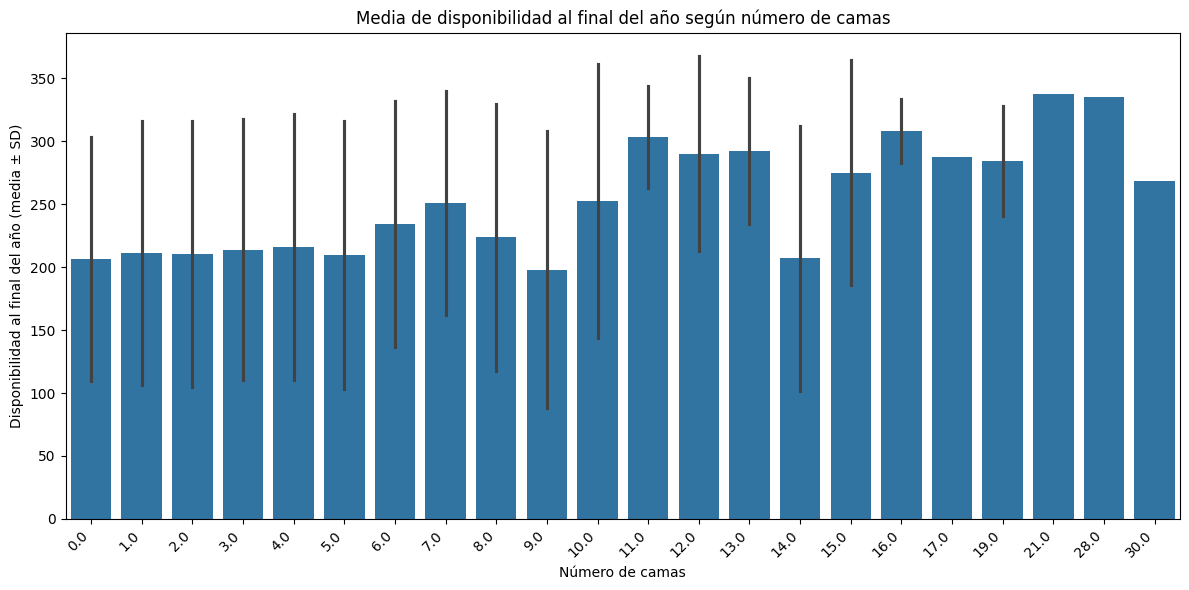

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_listings_limpio, x='beds', y='availability_eoy', estimator='mean', errorbar='sd')
plt.title("Media de disponibilidad al final del año según número de camas")
plt.xlabel("Número de camas")
plt.ylabel("Disponibilidad al final del año (media ± SD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Las conclusiones son similares a las obtenidas para habitaciones
- A medida que aumenta la cantidad de camas, la disponibilidad promedio es mayor, por lo que tienen una ocupación menor
- Las propiedades de más de 5 camas son escasas, por lo que los promedios calculados a partir de las mismas pueden llegar a ser menos representativos

### 4.4 ¿Existen patrones de precios según la ubicación, por ejemplo, en barrios específicos?

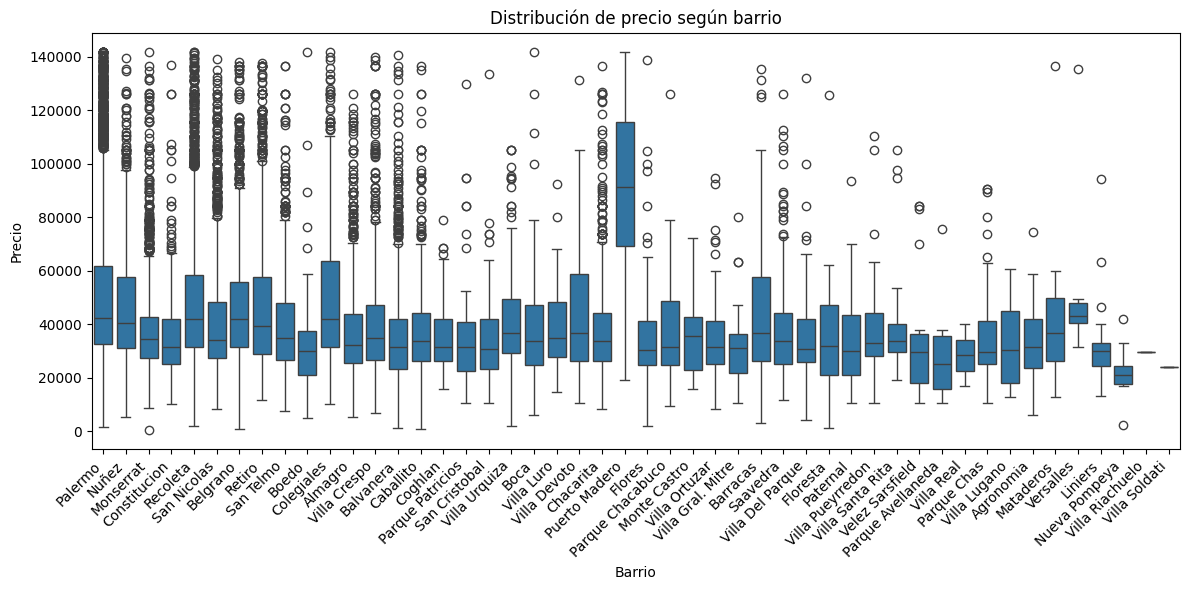

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_listings_limpio, x='neighbourhood_cleansed', y='price')
plt.xticks(rotation=45)
plt.title("Distribución de precio según barrio")
plt.xlabel("Barrio")
plt.ylabel("Precio")
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Se observa una gran diferencia de precio en Puerto Madero con respecto al resto. Luego barrios como Palermo, Recoleta, Colegiales y Belgrano tienen mayor precio que el resto

#### Gráfico de precio y reviews por barrio

In [59]:

# borramos las filas nulas de latitud, longitud y review_scores_value
df = dfs["df_listings_details"].dropna(subset=["latitude", "longitude", "review_scores_value"]).copy()

# Create GeoDataFrame
gdf_listings = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

In [60]:
#aseguramos que el GeoDataFrame de listings tenga el mismo CRS que el de barrios
gdf_neigh = dfs["df_neighbourhoods_geojson"]
gdf_listings = gdf_listings.to_crs(gdf_neigh.crs)

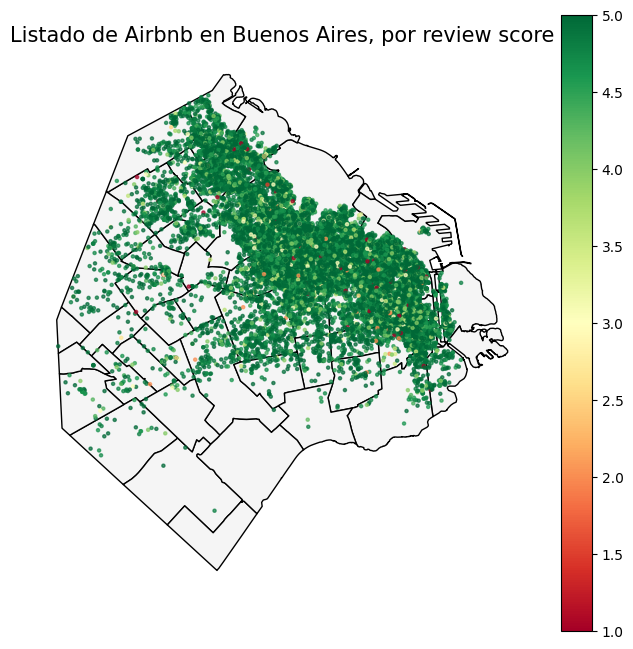

In [61]:

#Graficamos los barrios y los listados de Airbnb en Buenos Aires, coloreando por review_scores_value
fig, ax = plt.subplots(figsize=(8, 8))

# Plot neighborhoods in light grey
gdf_neigh.plot(ax=ax, edgecolor='black', facecolor='whitesmoke')

# Plot listings colored by review score
gdf_listings.plot(
    ax=ax,
    column='review_scores_value',
    cmap='RdYlGn',  # Red-Yellow-Green color scale
    markersize=5,
    legend=True,
    alpha=0.7
)

# Add title and remove axes
ax.set_title("Listado de Airbnb en Buenos Aires, por review score", fontsize=15)
plt.axis('off')
plt.show()


In [62]:
# Recuperamos Lat y Long, junto con el precio, para crear un GeoDataFrame
df_valid = df_listings_limpio.dropna(subset=['latitude', 'longitude', 'price', 'neighbourhood_cleansed'])

# Creamos los Puntos en base a lat/lon
geometry = [Point(xy) for xy in zip(df_valid['longitude'], df_valid['latitude'])]
gdf_listings = gpd.GeoDataFrame(df_valid, geometry=geometry, crs="EPSG:4326")

In [63]:
# realizamos un join espacial entre los listados y los barrios
gdf_joined = gpd.sjoin(gdf_listings, gdf_neigh, how="inner", predicate="within")


In [64]:
avg_price_by_neigh = gdf_joined.groupby("neighbourhood_cleansed")["price"].mean().astype(int).reset_index()

avg_price_by_neigh.columns = ["neighbourhood", "avg_price"]


In [65]:
avg_price_by_neigh["avg_price"] = avg_price_by_neigh["avg_price"].round().astype(int)


In [66]:
avg_price_by_neigh["avg_price_display"] = avg_price_by_neigh["avg_price"].apply(lambda x: f"{x:,.0f}")


In [67]:
df_listings_details['price'].sort_values(ascending=False).head(100)

6870     105021704.0
10552     63013022.0
29334     61920797.0
29331     61920797.0
16740     60012405.0
            ...     
7244        876176.0
5155        873781.0
5240        870178.0
33677       840174.0
25890       840174.0
Name: price, Length: 100, dtype: float64

In [68]:
avg_price_by_neigh

,neighbourhood,avg_price,avg_price_display
0,Agronomia,33968,"33,968"
1,Almagro,37366,"37,366"
2,Balvanera,35643,"35,643"
3,Barracas,43454,"43,454"
4,Belgrano,47016,"47,016"
5,Boca,39310,"39,310"
6,Boedo,32657,"32,657"
7,Caballito,38288,"38,288"
8,Chacarita,39293,"39,293"
9,Coghlan,35628,"35,628"


In [69]:
gdf_neigh_avg = gdf_neigh.merge(avg_price_by_neigh, on="neighbourhood", how="left")


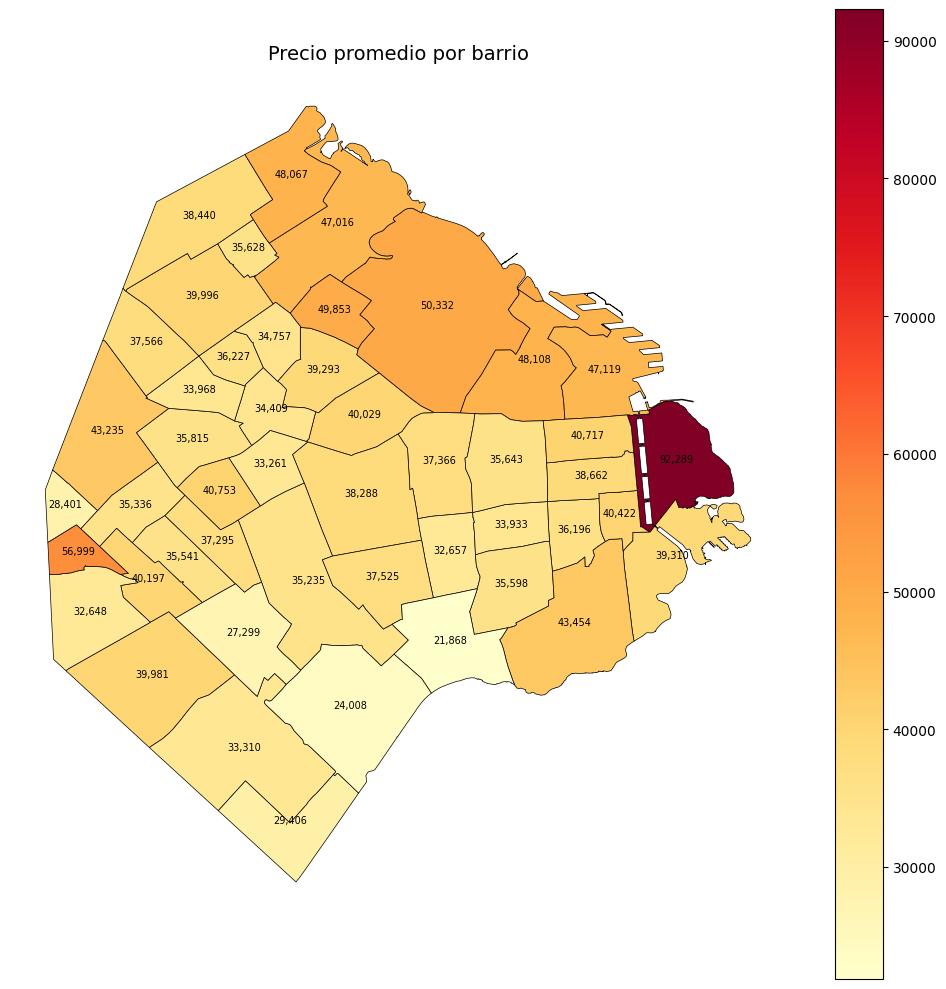

In [70]:
gdf_neigh_avg = gdf_neigh.merge(avg_price_by_neigh, on="neighbourhood", how="left")

fig, ax = plt.subplots(figsize=(10, 10))
gdf_neigh_avg.plot(
    column="avg_price",  # use numeric for color
    cmap="YlOrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Optional: add labels using formatted values
for idx, row in gdf_neigh_avg.iterrows():
    if pd.notnull(row["avg_price"]):
        plt.annotate(
            text=row["avg_price_display"],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha="center",
            fontsize=7,
            color="black"
        )

ax.set_title("Precio promedio por barrio", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


### 4.5 ¿Cómo varía la ocupación de las propiedades de acuerdo al mes? ¿Hay temporadas de mayor ocupación?

In [71]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'], errors='coerce')
df_calendar['month'] = df_calendar['date'].dt.month

# Convertimos la columna 'available' a booleana para facilitar el conteo
df_calendar['ocupada'] = df_calendar['available'] == 'f'

In [72]:
# Agrupamos por listing_id y month
df_calendar_mes = df_calendar.groupby(['listing_id', 'month'])

# Calculamos el porcentaje de no disponibilidad
ocupacion_mensual = df_calendar_mes['ocupada'].mean().reset_index()

# Renombramos la columna para claridad
ocupacion_mensual.rename(columns={'ocupada': 'Porcentaje_ocupacion_mensual'}, inplace=True)
ocupacion_mensual

,listing_id,month,Porcentaje_ocupacion_mensual
0,11508,1,0.064516
1,11508,2,0.857143
2,11508,3,1.000000
3,11508,4,0.266667
4,11508,5,0.000000
...,...,...,...
422059,1344330090094885732,8,0.000000
422060,1344330090094885732,9,0.000000
422061,1344330090094885732,10,0.000000
422062,1344330090094885732,11,0.000000


In [73]:
ocupacion_mensual_agregada = ocupacion_mensual.groupby('month')['Porcentaje_ocupacion_mensual'].mean().reset_index()
ocupacion_mensual_agregada

,month,Porcentaje_ocupacion_mensual
0,1,0.599605
1,2,0.492378
2,3,0.377703
3,4,0.290048
4,5,0.335325
5,6,0.314730
6,7,0.320264
7,8,0.431360
8,9,0.426093
9,10,0.448420


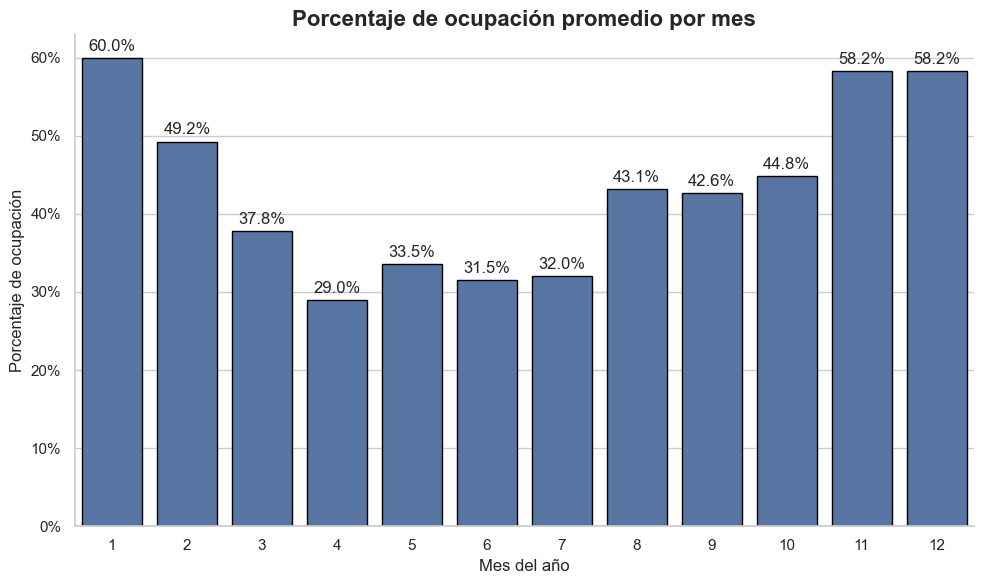

In [74]:
from matplotlib.ticker import PercentFormatter

# Estilo de seaborn
sns.set(style='whitegrid')

# Tamaño de la figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con paleta moderna y bordes
ax = sns.barplot(
    data=ocupacion_mensual_agregada,
    x='month',
    y='Porcentaje_ocupacion_mensual',
    edgecolor='black'
)

# Formato del eje Y como porcentaje
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Agregar etiquetas encima de cada barra
for container in ax.containers:
    labels = [f'{v.get_height() * 100:.1f}%' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3)

# Títulos y etiquetas
plt.title('Porcentaje de ocupación promedio por mes', fontsize=16, weight='bold')
plt.xlabel('Mes del año', fontsize=12)
plt.ylabel('Porcentaje de ocupación', fontsize=12)

# Quitar spines para estética más limpia
sns.despine()

# Mostrar gráfico
plt.tight_layout()
plt.show()


Se observa un promedio de ocupación más alto en los meses de verano, en particular Noviembre, Diciembre y Enero

In [75]:
ocupacion_mensual_con_barrio = pd.merge(ocupacion_mensual, df_listings_details[['id', 'neighbourhood_cleansed']], how='left', left_on='listing_id', right_on='id')
ocupacion_mensual_agregada_barrio = ocupacion_mensual_con_barrio.groupby(['neighbourhood_cleansed','month'])['Porcentaje_ocupacion_mensual'].mean().reset_index()
ocupacion_mensual_agregada_barrio.rename(columns={'neighbourhood_cleansed': 'Barrio'}, inplace = True)
ocupacion_mensual_agregada_barrio

,Barrio,month,Porcentaje_ocupacion_mensual
0,Agronomia,1,0.597670
1,Agronomia,2,0.500992
2,Agronomia,3,0.353943
3,Agronomia,4,0.338889
4,Agronomia,5,0.309140
...,...,...,...
571,Villa Urquiza,8,0.423863
572,Villa Urquiza,9,0.419357
573,Villa Urquiza,10,0.444462
574,Villa Urquiza,11,0.589076


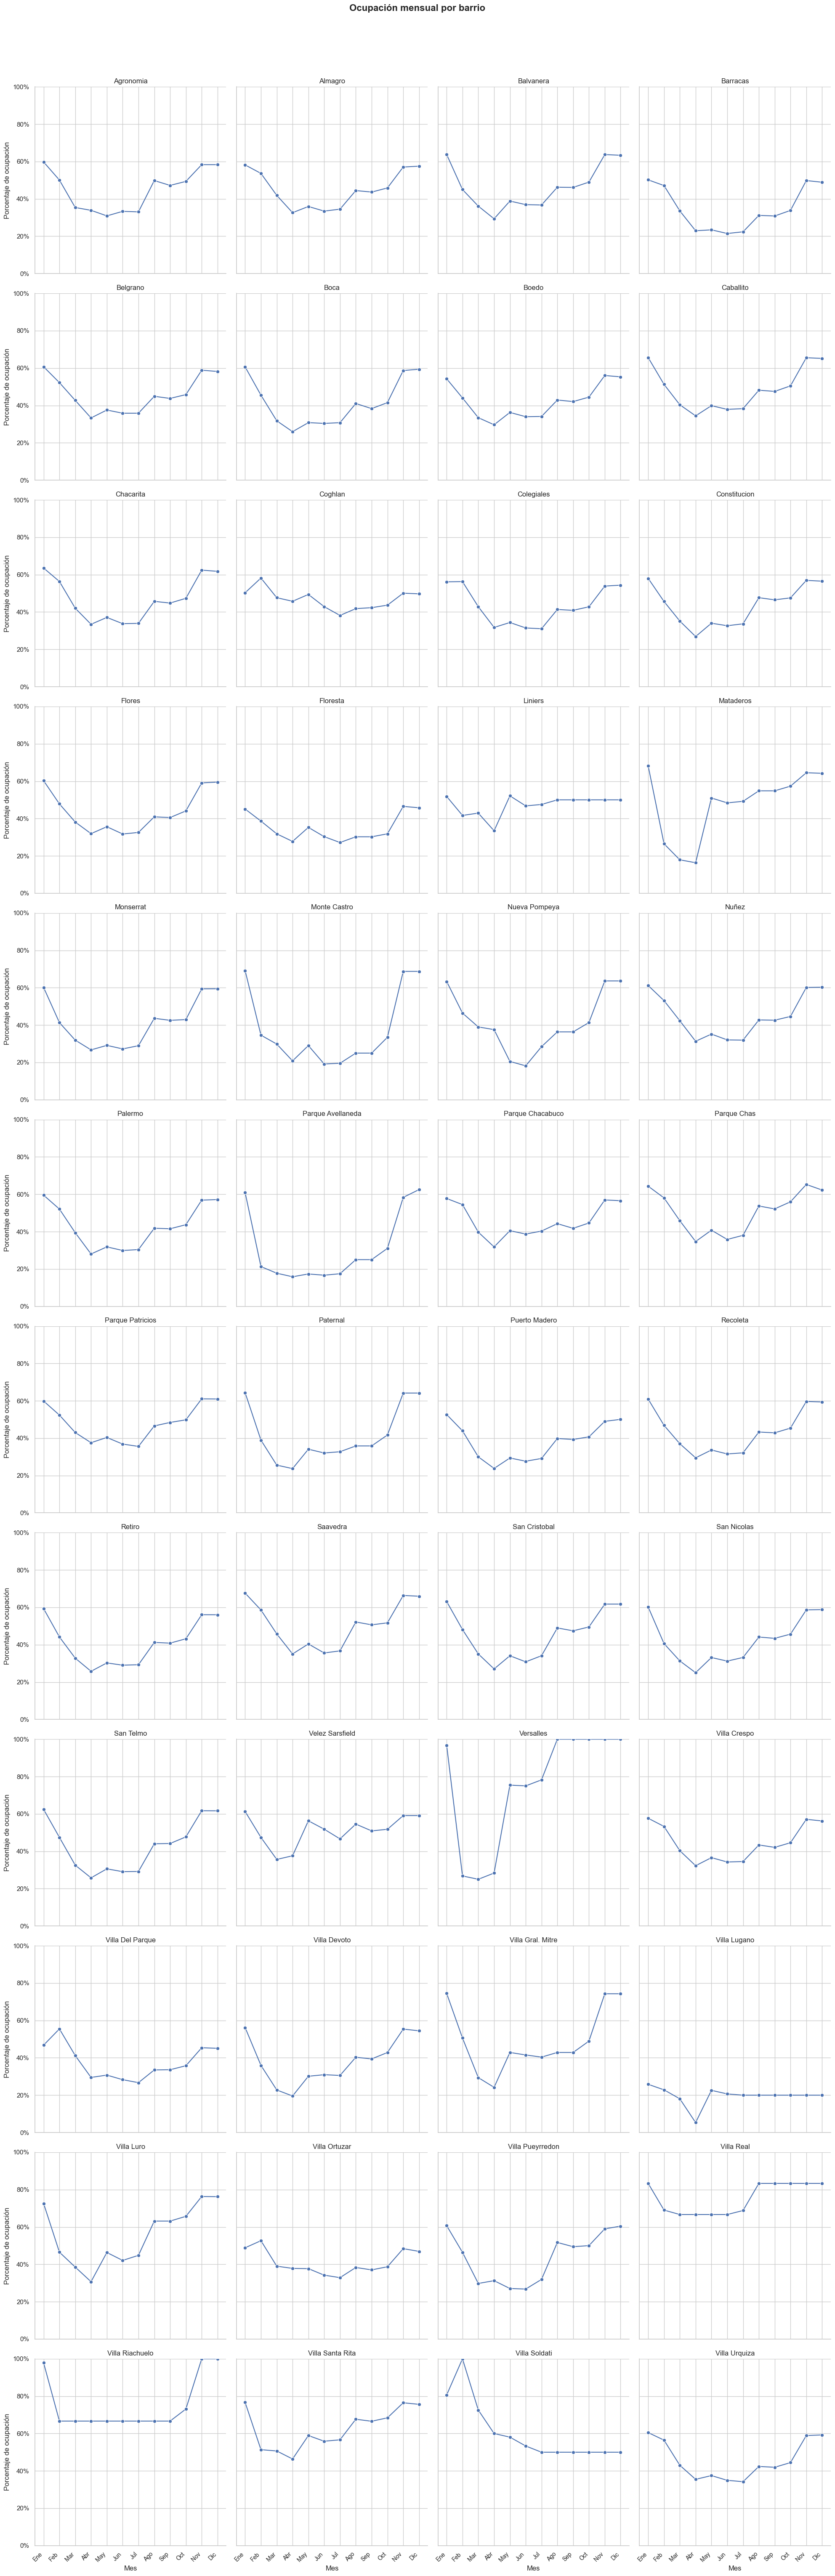

In [76]:
from matplotlib.ticker import PercentFormatter

# Definir etiquetas de meses
month_labels = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'
}

# Verificar el formato de la columna 'month'
if pd.api.types.is_numeric_dtype(ocupacion_mensual_agregada_barrio['month']):
    month_ticks = list(month_labels.keys())
    month_labels_list = list(month_labels.values())
else:
    month_order = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
                   'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    month_ticks = range(len(month_order))
    month_labels_list = month_order
    ocupacion_mensual_agregada_barrio['month'] = pd.Categorical(
        ocupacion_mensual_agregada_barrio['month'], categories=month_order, ordered=True
    )

# Crear el gráfico relplot
g = sns.relplot(
    data=ocupacion_mensual_agregada_barrio,
    x='month',
    y='Porcentaje_ocupacion_mensual',
    col='Barrio',
    kind='line',
    marker='o',
    col_wrap=4,
    facet_kws={'sharey': True, 'sharex': True}
)

# Configurar títulos y etiquetas
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Mes", "Porcentaje de ocupación")
g.set(ylim=(0, 1))
g.figure.suptitle("Ocupación mensual por barrio", fontsize=16, weight='bold', y=1.02)
g.set_ylabels("Porcentaje de ocupación")

# Formatear ejes y asegurar xticks en cada subgráfico
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_labels_list, rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()